# Loading Libraries

In [31]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
import pandas as pd

import torch.utils.data
from torch import optim
import os
import skfda
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import itertools 
from sklearn.decomposition import PCA
import matplotlib as mpl
from sklearn.neighbors import LocalOutlierFactor


mpl.rcParams['figure.dpi'] = 300

# Loading Files

In [2]:
def wf(x):
    return '/Users/pruthvibharadwaj/Desktop/Spring 22/MA679 - ML/Project/Data/' + x

In [36]:
V_GRF_stance_N = pd.read_csv(wf('V_GRF_stance_N.csv'), header = None)
ML_GRF_stance_N = pd.read_csv(wf('ML_GRF_stance_N.csv'), header = None)
AP_GRF_stance_N = pd.read_csv(wf('AP_GRF_stance_N.csv'), header = None)
ID_info = pd.read_csv(wf('IDinfo.csv'), header = None)

In [37]:
V_GRF_stance_N_matrix = V_GRF_stance_N.to_numpy()
ML_GRF_stance_N_matrix = ML_GRF_stance_N.to_numpy()
AP_GRF_stance_N_matrix = AP_GRF_stance_N.to_numpy()
ID_info_matrix = ID_info.to_numpy()

In [5]:
#Defining a list of grid points
grid_points_100 = list(range(1,101))
grid_points_2990 = list(range(1,2991))

In [6]:
V_GRF_stance_N_fd = skfda.FDataGrid(data_matrix=V_GRF_stance_N_matrix,grid_points=grid_points_100)
V_GRF_stance_N_mean = skfda.exploratory.stats.mean(V_GRF_stance_N_fd)

ML_GRF_stance_N_fd = skfda.FDataGrid(data_matrix=ML_GRF_stance_N_matrix,grid_points=grid_points_100)
ML_GRF_stance_N_mean = skfda.exploratory.stats.mean(ML_GRF_stance_N_fd)

AP_GRF_stance_N_fd = skfda.FDataGrid(data_matrix=AP_GRF_stance_N_matrix,grid_points=grid_points_100)
AP_GRF_stance_N_mean = skfda.exploratory.stats.mean(AP_GRF_stance_N_fd)

In [7]:
V_GRF_stance_N_mean_array = np.zeros((15696,100))
for j in range(0,15696):
    for i in range(0,100):
        val = V_GRF_stance_N_mean.data_matrix[0,i,0]
        V_GRF_stance_N_mean_array[j,i] = val
    
ML_GRF_stance_N_mean_array = np.zeros((15696,100))
for j in range(0,15696):
    for i in range(0,100):
        val = ML_GRF_stance_N_mean.data_matrix[0,i,0]
        ML_GRF_stance_N_mean_array[j,i] = val
    
AP_GRF_stance_N_mean_array = np.zeros((15696,100))
for j in range(0,15696):
    for i in range(0,100):
        val = AP_GRF_stance_N_mean.data_matrix[0,i,0]
        AP_GRF_stance_N_mean_array[j,i] = val

# Defining VAE

In [8]:
class InfoVAE(nn.Module):
    def __init__(self,nfeat=100, ncode=5, alpha=0, lambd=10000, nhidden=128, nhidden2=35, dropout=0.2):
        super(InfoVAE, self).__init__()
        
        self.ncode = int(ncode)
        self.alpha = float(alpha)
        self.lambd = float(lambd)
        
        self.encd = nn.Linear(nfeat, nhidden)
        self.d1 = nn.Dropout(p=dropout)
        self.enc2 = nn.Linear(nhidden, nhidden2)
        self.d2 = nn.Dropout(p=dropout)
        self.mu = nn.Linear(nhidden2, ncode)
        self.lv = nn.Linear(nhidden2, ncode)
        
        self.decd = nn.Linear(ncode, nhidden2)
        self.d3 = nn.Dropout(p=dropout)
        self.dec2 = nn.Linear(nhidden2, nhidden)
        self.d4 = nn.Dropout(p=dropout)
        self.outp = nn.Linear(nhidden, nfeat)
        
    def encode(self, x):
        x = self.d1(F.leaky_relu(self.encd(x)))
        x = self.d2(F.leaky_relu(self.enc2(x)))
        mu = self.mu(x)
        logvar = self.lv(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, x):
        x = self.d3(F.leaky_relu(self.decd(x)))
        x = self.d4(F.leaky_relu(self.dec2(x)))
        x = self.outp(x)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    # https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/
    def compute_kernel(self, x, y):
        x_size = x.size(0)
        y_size = y.size(0)
        dim = x.size(1)
        x = x.unsqueeze(1) # (x_size, 1, dim)
        y = y.unsqueeze(0) # (1, y_size, dim)
        tiled_x = x.expand(x_size, y_size, dim)
        tiled_y = y.expand(x_size, y_size, dim)
        # The example code divides by (dim) here, making <kernel_input> ~ 1/dim
        # excluding (dim) makes <kernel_input> ~ 1
        kernel_input = (tiled_x - tiled_y).pow(2).mean(2)#/float(dim)
        return torch.exp(-kernel_input) # (x_size, y_size)
    
    # https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/
    def compute_mmd(self, x, y):
        xx_kernel = self.compute_kernel(x,x)
        yy_kernel = self.compute_kernel(y,y)
        xy_kernel = self.compute_kernel(x,y)
        return torch.mean(xx_kernel) + torch.mean(yy_kernel) - 2*torch.mean(xy_kernel)
    
    def loss(self, x, epoch):
        recon_x, mu, logvar = self.forward(x)
        MSE = torch.sum(0.5 *  (x - recon_x).pow(2))
        
        # KL divergence (Kingma and Welling, https://arxiv.org/abs/1312.6114, Appendix B)
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        #return MSE + self.beta*KLD, MSE
                
        # https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/
        true_samples = Variable(torch.randn(200, self.ncode), requires_grad=False)
        z = self.reparameterize(mu, logvar) #duplicate call
        # compute MMD ~ 1, so upweight to match KLD which is ~ n_batch x n_code
        MMD = self.compute_mmd(true_samples,z) * x.size(0) * self.ncode
        return MSE + (1-self.alpha)*KLD + (self.lambd+self.alpha-1)*MMD, MSE, KLD, MMD

# Preparing Test and Train datasets for model fitting

# MLGRF

In [9]:
trainfrac = 0.75
ntrain = int(ML_GRF_stance_N_matrix.shape[0] * trainfrac)
nvalid = ML_GRF_stance_N_matrix.shape[0] - ntrain
nfeat = ML_GRF_stance_N_matrix.shape[1]
np.random.seed(20190425) # make validation set deterministic
permutation = np.random.permutation(ML_GRF_stance_N_matrix.shape[0])
np.random.seed()
trainidx = permutation[0:ntrain]
valididx = permutation[-1-nvalid:-1]

train_mlgrf = ML_GRF_stance_N_matrix[trainidx,:]
valid_mlgrf = ML_GRF_stance_N_matrix[valididx,:]

In [10]:
batch_size=64

dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(train_mlgrf, dtype=torch.float32)),
    batch_size=batch_size,
    shuffle=True)

valdloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(valid_mlgrf, dtype=torch.float32)),
    batch_size=nvalid)

## Defining Training function

In [11]:
def train(): #model, optimizer, epoch, min_valid_loss, badepochs
    model.train()
    train_loss = 0
    train_logL = 0
    for batch_idx, data in enumerate(dataloader):
        spectrum = data[0]
        optimizer.zero_grad()
        loss, logL, KLD, MMD = model.loss(spectrum, epoch)
        loss.backward()
        train_loss += loss.item()
        train_logL += logL.item()
        optimizer.step()
    train_loss /= len(dataloader.dataset)
    
    with torch.no_grad():
        model.eval()
        valid_loss = 0
        valid_logL = 0
        valid_KLD = 0
        valid_MMD = 0

        for valddata in valdloader:
            spectrum = valddata[0]
            loss, logL, KLD, MMD = model.loss(spectrum, epoch)
            valid_loss += loss.item()
            valid_logL += logL.item()
            valid_KLD += KLD.item()
            valid_MMD += MMD.item()
        
        valid_loss /= len(valdloader.dataset)
        valid_logL /= -len(valdloader.dataset)
        valid_KLD  /= len(valdloader.dataset)
        valid_MMD  /= len(valdloader.dataset)
    return valid_loss, valid_logL, valid_KLD, valid_MMD

In [12]:
class EarlyStopper:
    def __init__(self, precision=1e-3, patience=10):
        self.precision = precision
        self.patience = patience
        self.badepochs = 0
        self.min_valid_loss = float('inf')
        
    def step(self, valid_loss):
        if valid_loss < self.min_valid_loss*(1-self.precision):
            self.badepochs = 0
            self.min_valid_loss = valid_loss
        else:
            self.badepochs += 1
        return not (self.badepochs == self.patience)

# Setting training parameters

In [13]:
epochs = 200
log_interval = 10
mdl_ncode_l = range(2,11,2)
n_config_l = range(100)
test_list = [n_config_l,mdl_ncode_l]

mdl_MSE = np.zeros((100, 5))
mdl_KLD = np.zeros((100, 5))
mdl_MMD = np.zeros((100, 5))

In [14]:
tag = '/Users/pruthvibharadwaj/Desktop/Spring 22/MA679 - ML/Project/Models/GRFx'
# Parent Directory path
parent_dir = '/Users/pruthvibharadwaj/Desktop/Spring 22/MA679 - ML/Project/Models/'
# Path

# Training 100 models for 5 different encoder shapes

In [15]:
for config, mdl_ncode in itertools.product(n_config_l,mdl_ncode_l):
    alpha = 0
    lambd = np.exp(np.random.uniform(0, np.log(1e5)))
    dropout = 0#0.9*np.random.uniform()
    dfac = 1./(1.-dropout)
    nhidden = int(np.ceil(np.exp(np.random.uniform(np.log(dfac*mdl_ncode+1), np.log(dfac*2*nfeat)))))
    nhidden2 = int(np.ceil(np.exp(np.random.uniform(np.log(dfac*mdl_ncode+1), np.log(nhidden)))))
    print('config %i, alpha = %0.1f, lambda = %0.1f, dropout = %0.2f; 2 hidden layers with %i, %i nodes' % (config, alpha, lambd, dropout, nhidden, nhidden2))
    model = InfoVAE(alpha=alpha, lambd=lambd, nfeat=nfeat, nhidden=nhidden, nhidden2=nhidden2, ncode=mdl_ncode, dropout=dropout)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=5)
    stopper = EarlyStopper(patience=10)

    for epoch in range(1, epochs + 1):
        valid_loss, valid_logL, valid_KLD, valid_MMD = train()
        if epoch % log_interval == 0:
            print('====> Epoch: {} VALIDATION Loss: {:.2e} logL: {:.2e} KL: {:.2e} MMD: {:.2e}'.format(
                  epoch, valid_loss, valid_logL, valid_KLD, valid_MMD))

        scheduler.step(valid_loss)
        if (not stopper.step(valid_loss)) or (epoch == epochs):
            
            if mdl_ncode == 2:
                p_i = 0
            elif mdl_ncode == 4:
                p_i = 1
            elif mdl_ncode == 6:
                p_i = 2
            elif mdl_ncode == 8:
                p_i = 3
            elif mdl_ncode == 10:
                p_i = 4
                
            print('Stopping')
            print('====> Epoch: {} VALIDATION Loss: {:.2e} logL: {:.2e} KL: {:.2e} MMD: {:.2e}'.format(
                  epoch, valid_loss, valid_logL, valid_KLD, valid_MMD))
            model.MSE = -valid_logL
            model.KLD = valid_KLD
            model.MMD = valid_MMD
            mdl_MSE[config,p_i] = model.MSE
            mdl_KLD[config,p_i] = model.KLD
            mdl_MMD[config,p_i] = model.MMD
            torch.save(model, tag +'/%i' % mdl_ncode +'/%04i.pth' % config  )
            break


config 0, alpha = 0.0, lambda = 2694.9, dropout = 0.00; 2 hidden layers with 17, 6 nodes
====> Epoch: 10 VALIDATION Loss: 9.32e+03 logL: -7.06e+03 KL: 7.92e+01 MMD: 8.09e-01
====> Epoch: 20 VALIDATION Loss: 7.99e+03 logL: -5.74e+03 KL: 6.68e+01 MMD: 8.10e-01
====> Epoch: 30 VALIDATION Loss: 7.23e+03 logL: -5.19e+03 KL: 9.19e+01 MMD: 7.25e-01
====> Epoch: 40 VALIDATION Loss: 6.63e+03 logL: -4.66e+03 KL: 8.49e+01 MMD: 7.02e-01
====> Epoch: 50 VALIDATION Loss: 5.42e+03 logL: -4.83e+03 KL: 5.97e+00 MMD: 2.14e-01
Epoch 00059: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 60 VALIDATION Loss: 3.05e+04 logL: -2.92e+04 KL: 1.16e+02 MMD: 4.31e-01
Stopping
====> Epoch: 63 VALIDATION Loss: 3.01e+04 logL: -2.87e+04 KL: 1.16e+02 MMD: 4.72e-01
config 0, alpha = 0.0, lambda = 9.3, dropout = 0.00; 2 hidden layers with 27, 7 nodes
====> Epoch: 10 VALIDATION Loss: 5.65e+03 logL: -5.48e+03 KL: 1.66e+02 MMD: 1.20e+00
====> Epoch: 20 VALIDATION Loss: 5.28e+03 logL: -5.19e+03 KL: 8.50e+01 MMD

====> Epoch: 10 VALIDATION Loss: 5.42e+03 logL: -4.20e+03 KL: 1.55e+02 MMD: 1.69e+00
====> Epoch: 20 VALIDATION Loss: 4.76e+03 logL: -3.63e+03 KL: 7.74e+01 MMD: 1.66e+00
====> Epoch: 30 VALIDATION Loss: 2.82e+03 logL: -2.60e+03 KL: 3.36e+01 MMD: 3.03e-01
====> Epoch: 40 VALIDATION Loss: 2.71e+03 logL: -2.55e+03 KL: 3.35e+01 MMD: 1.97e-01
====> Epoch: 50 VALIDATION Loss: 2.50e+03 logL: -2.36e+03 KL: 3.27e+01 MMD: 1.71e-01
====> Epoch: 60 VALIDATION Loss: 1.56e+03 logL: -1.43e+03 KL: 3.36e+01 MMD: 1.49e-01
====> Epoch: 70 VALIDATION Loss: 1.43e+03 logL: -1.32e+03 KL: 3.01e+01 MMD: 1.23e-01
====> Epoch: 80 VALIDATION Loss: 1.40e+03 logL: -1.30e+03 KL: 2.86e+01 MMD: 1.03e-01
Epoch 00088: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 90 VALIDATION Loss: 1.38e+03 logL: -1.28e+03 KL: 2.73e+01 MMD: 1.23e-01
====> Epoch: 100 VALIDATION Loss: 1.34e+03 logL: -1.28e+03 KL: 2.70e+01 MMD: 5.97e-02
Epoch 00100: reducing learning rate of group 0 to 1.0000e-05.
Stopping
====> Epoch: 104

====> Epoch: 120 VALIDATION Loss: 3.64e+03 logL: -3.61e+03 KL: 1.76e+01 MMD: 7.83e-01
====> Epoch: 130 VALIDATION Loss: 3.63e+03 logL: -3.61e+03 KL: 1.73e+01 MMD: 7.67e-01
Stopping
====> Epoch: 131 VALIDATION Loss: 3.64e+03 logL: -3.61e+03 KL: 1.73e+01 MMD: 8.04e-01
config 3, alpha = 0.0, lambda = 59255.7, dropout = 0.00; 2 hidden layers with 90, 32 nodes
====> Epoch: 10 VALIDATION Loss: 6.05e+03 logL: -5.16e+03 KL: 4.76e+00 MMD: 1.50e-02
====> Epoch: 20 VALIDATION Loss: 6.41e+03 logL: -4.75e+03 KL: 6.98e+00 MMD: 2.78e-02
====> Epoch: 30 VALIDATION Loss: 5.81e+03 logL: -4.59e+03 KL: 7.52e+00 MMD: 2.05e-02
Epoch 00030: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 40 VALIDATION Loss: 5.04e+03 logL: -4.41e+03 KL: 8.18e+00 MMD: 1.04e-02
Epoch 00040: reducing learning rate of group 0 to 1.0000e-05.
Stopping
====> Epoch: 44 VALIDATION Loss: 5.41e+03 logL: -4.39e+03 KL: 8.26e+00 MMD: 1.71e-02
config 3, alpha = 0.0, lambda = 48.7, dropout = 0.00; 2 hidden layers with 26, 11 no

====> Epoch: 50 VALIDATION Loss: 1.00e+03 logL: -9.44e+02 KL: 5.09e+01 MMD: 1.65e+00
====> Epoch: 60 VALIDATION Loss: 9.82e+02 logL: -9.27e+02 KL: 4.76e+01 MMD: 1.60e+00
Epoch 00060: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 70 VALIDATION Loss: 9.70e+02 logL: -9.15e+02 KL: 4.72e+01 MMD: 1.45e+00
====> Epoch: 80 VALIDATION Loss: 9.66e+02 logL: -9.12e+02 KL: 4.67e+01 MMD: 1.54e+00
====> Epoch: 90 VALIDATION Loss: 8.46e+02 logL: -7.68e+02 KL: 6.73e+01 MMD: 2.22e+00
====> Epoch: 100 VALIDATION Loss: 8.16e+02 logL: -7.46e+02 KL: 6.02e+01 MMD: 2.12e+00
====> Epoch: 110 VALIDATION Loss: 8.07e+02 logL: -7.41e+02 KL: 5.56e+01 MMD: 2.13e+00
====> Epoch: 120 VALIDATION Loss: 8.02e+02 logL: -7.38e+02 KL: 5.29e+01 MMD: 2.11e+00
====> Epoch: 130 VALIDATION Loss: 7.97e+02 logL: -7.37e+02 KL: 5.09e+01 MMD: 1.90e+00
====> Epoch: 140 VALIDATION Loss: 7.96e+02 logL: -7.38e+02 KL: 4.92e+01 MMD: 1.85e+00
====> Epoch: 150 VALIDATION Loss: 7.94e+02 logL: -7.37e+02 KL: 4.82e+01 MMD: 1.85e+

====> Epoch: 40 VALIDATION Loss: 2.30e+03 logL: -1.06e+03 KL: 5.88e+01 MMD: 1.26e+00
====> Epoch: 50 VALIDATION Loss: 1.82e+03 logL: -1.16e+03 KL: 3.60e+01 MMD: 6.65e-01
====> Epoch: 60 VALIDATION Loss: 1.31e+03 logL: -1.11e+03 KL: 3.31e+01 MMD: 1.79e-01
====> Epoch: 70 VALIDATION Loss: 1.16e+03 logL: -1.07e+03 KL: 3.35e+01 MMD: 6.48e-02
Epoch 00074: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 80 VALIDATION Loss: 1.12e+03 logL: -1.03e+03 KL: 3.39e+01 MMD: 5.93e-02
Epoch 00084: reducing learning rate of group 0 to 1.0000e-06.
Stopping
====> Epoch: 88 VALIDATION Loss: 1.14e+03 logL: -1.03e+03 KL: 3.40e+01 MMD: 8.11e-02
config 6, alpha = 0.0, lambda = 914.9, dropout = 0.00; 2 hidden layers with 84, 11 nodes
====> Epoch: 10 VALIDATION Loss: 6.95e+03 logL: -5.26e+03 KL: 1.39e+02 MMD: 1.70e+00
====> Epoch: 20 VALIDATION Loss: 5.54e+03 logL: -3.89e+03 KL: 1.11e+02 MMD: 1.69e+00
====> Epoch: 30 VALIDATION Loss: 3.27e+03 logL: -2.89e+03 KL: 3.05e+01 MMD: 3.86e-01
====> Epoch: 

====> Epoch: 10 VALIDATION Loss: 5.69e+03 logL: -4.09e+03 KL: 9.17e+00 MMD: 2.91e-02
====> Epoch: 20 VALIDATION Loss: 4.14e+03 logL: -3.53e+03 KL: 1.13e+01 MMD: 1.10e-02
Epoch 00027: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 30 VALIDATION Loss: 4.01e+03 logL: -3.42e+03 KL: 1.27e+01 MMD: 1.06e-02
Epoch 00035: reducing learning rate of group 0 to 1.0000e-05.
Stopping
====> Epoch: 39 VALIDATION Loss: 3.63e+03 logL: -3.39e+03 KL: 1.29e+01 MMD: 4.11e-03
config 8, alpha = 0.0, lambda = 11140.2, dropout = 0.00; 2 hidden layers with 67, 37 nodes
====> Epoch: 10 VALIDATION Loss: 3.66e+03 logL: -3.01e+03 KL: 1.78e+01 MMD: 5.61e-02
====> Epoch: 20 VALIDATION Loss: 3.37e+03 logL: -2.77e+03 KL: 1.69e+01 MMD: 5.22e-02
====> Epoch: 30 VALIDATION Loss: 2.78e+03 logL: -2.60e+03 KL: 1.69e+01 MMD: 1.50e-02
Epoch 00034: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 40 VALIDATION Loss: 2.72e+03 logL: -2.51e+03 KL: 1.78e+01 MMD: 1.71e-02
Epoch 00047: reducing learning rat

Epoch 00044: reducing learning rate of group 0 to 1.0000e-05.
Stopping
====> Epoch: 48 VALIDATION Loss: 3.32e+03 logL: -2.62e+03 KL: 1.66e+01 MMD: 3.02e-02
config 9, alpha = 0.0, lambda = 4.2, dropout = 0.00; 2 hidden layers with 93, 47 nodes
====> Epoch: 10 VALIDATION Loss: 1.00e+03 logL: -9.02e+02 KL: 9.67e+01 MMD: 1.87e+00
====> Epoch: 20 VALIDATION Loss: 6.58e+02 logL: -5.77e+02 KL: 7.47e+01 MMD: 1.78e+00
====> Epoch: 30 VALIDATION Loss: 5.68e+02 logL: -5.02e+02 KL: 6.02e+01 MMD: 1.78e+00
Epoch 00038: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 40 VALIDATION Loss: 5.51e+02 logL: -4.90e+02 KL: 5.52e+01 MMD: 1.72e+00
====> Epoch: 50 VALIDATION Loss: 5.43e+02 logL: -4.84e+02 KL: 5.43e+01 MMD: 1.55e+00
====> Epoch: 60 VALIDATION Loss: 4.77e+02 logL: -4.16e+02 KL: 5.58e+01 MMD: 1.65e+00
====> Epoch: 70 VALIDATION Loss: 4.66e+02 logL: -4.07e+02 KL: 5.35e+01 MMD: 1.55e+00
====> Epoch: 80 VALIDATION Loss: 4.60e+02 logL: -4.03e+02 KL: 5.23e+01 MMD: 1.48e+00
====> Epoch: 90

====> Epoch: 40 VALIDATION Loss: 3.73e+03 logL: -3.65e+03 KL: 1.20e+01 MMD: 4.79e-02
====> Epoch: 50 VALIDATION Loss: 3.68e+03 logL: -3.62e+03 KL: 1.21e+01 MMD: 3.89e-02
====> Epoch: 60 VALIDATION Loss: 3.54e+03 logL: -3.47e+03 KL: 1.22e+01 MMD: 3.66e-02
====> Epoch: 70 VALIDATION Loss: 2.63e+03 logL: -2.56e+03 KL: 1.62e+01 MMD: 3.52e-02
====> Epoch: 80 VALIDATION Loss: 2.59e+03 logL: -2.54e+03 KL: 1.60e+01 MMD: 2.39e-02
====> Epoch: 90 VALIDATION Loss: 2.60e+03 logL: -2.53e+03 KL: 1.53e+01 MMD: 4.37e-02
====> Epoch: 100 VALIDATION Loss: 2.55e+03 logL: -2.50e+03 KL: 1.49e+01 MMD: 2.06e-02
Epoch 00103: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 110 VALIDATION Loss: 2.55e+03 logL: -2.49e+03 KL: 1.46e+01 MMD: 2.99e-02
Epoch 00119: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 120 VALIDATION Loss: 2.53e+03 logL: -2.49e+03 KL: 1.46e+01 MMD: 1.56e-02
Stopping
====> Epoch: 123 VALIDATION Loss: 2.55e+03 logL: -2.49e+03 KL: 1.45e+01 MMD: 3.30e-02
config 11, al

====> Epoch: 110 VALIDATION Loss: 6.38e+02 logL: -5.98e+02 KL: 3.87e+01 MMD: 1.21e+00
Epoch 00114: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 120 VALIDATION Loss: 6.30e+02 logL: -5.91e+02 KL: 3.78e+01 MMD: 1.37e+00
Stopping
====> Epoch: 126 VALIDATION Loss: 6.30e+02 logL: -5.90e+02 KL: 3.80e+01 MMD: 1.29e+00
config 12, alpha = 0.0, lambda = 2.3, dropout = 0.00; 2 hidden layers with 32, 18 nodes
====> Epoch: 10 VALIDATION Loss: 1.43e+03 logL: -1.31e+03 KL: 1.15e+02 MMD: 1.87e+00
====> Epoch: 20 VALIDATION Loss: 1.03e+03 logL: -9.58e+02 KL: 7.46e+01 MMD: 1.79e+00
====> Epoch: 30 VALIDATION Loss: 8.24e+02 logL: -7.56e+02 KL: 6.53e+01 MMD: 1.63e+00
====> Epoch: 40 VALIDATION Loss: 8.00e+02 logL: -7.42e+02 KL: 5.55e+01 MMD: 1.75e+00
====> Epoch: 50 VALIDATION Loss: 7.13e+02 logL: -6.58e+02 KL: 5.32e+01 MMD: 1.72e+00
====> Epoch: 60 VALIDATION Loss: 6.85e+02 logL: -6.33e+02 KL: 4.92e+01 MMD: 1.67e+00
====> Epoch: 70 VALIDATION Loss: 6.69e+02 logL: -6.20e+02 KL: 4.64e+01 MM

====> Epoch: 100 VALIDATION Loss: 2.58e+03 logL: -2.52e+03 KL: 2.61e+01 MMD: 1.53e-02
Epoch 00107: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 110 VALIDATION Loss: 2.58e+03 logL: -2.51e+03 KL: 2.60e+01 MMD: 1.69e-02
Stopping
====> Epoch: 110 VALIDATION Loss: 2.58e+03 logL: -2.51e+03 KL: 2.60e+01 MMD: 1.69e-02
config 14, alpha = 0.0, lambda = 336.1, dropout = 0.00; 2 hidden layers with 37, 12 nodes
====> Epoch: 10 VALIDATION Loss: 6.10e+03 logL: -5.48e+03 KL: 1.13e+02 MMD: 1.50e+00
====> Epoch: 20 VALIDATION Loss: 4.47e+03 logL: -3.85e+03 KL: 1.22e+02 MMD: 1.48e+00
====> Epoch: 30 VALIDATION Loss: 4.25e+03 logL: -3.68e+03 KL: 7.77e+01 MMD: 1.48e+00
====> Epoch: 40 VALIDATION Loss: 4.09e+03 logL: -3.65e+03 KL: 3.49e+01 MMD: 1.21e+00
====> Epoch: 50 VALIDATION Loss: 3.83e+03 logL: -3.74e+03 KL: 1.73e+01 MMD: 2.21e-01
====> Epoch: 60 VALIDATION Loss: 3.66e+03 logL: -3.60e+03 KL: 1.90e+01 MMD: 1.35e-01
====> Epoch: 70 VALIDATION Loss: 2.63e+03 logL: -2.56e+03 KL: 2.38e+01 

====> Epoch: 10 VALIDATION Loss: 8.96e+03 logL: -5.70e+03 KL: 7.41e+01 MMD: 5.58e-01
====> Epoch: 20 VALIDATION Loss: 5.30e+03 logL: -4.89e+03 KL: 8.74e+00 MMD: 7.14e-02
====> Epoch: 30 VALIDATION Loss: 3.88e+03 logL: -3.75e+03 KL: 1.52e+01 MMD: 1.86e-02
====> Epoch: 40 VALIDATION Loss: 3.92e+03 logL: -3.73e+03 KL: 1.39e+01 MMD: 3.04e-02
====> Epoch: 50 VALIDATION Loss: 3.76e+03 logL: -3.66e+03 KL: 1.27e+01 MMD: 1.56e-02
Epoch 00057: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 60 VALIDATION Loss: 3.72e+03 logL: -3.61e+03 KL: 1.23e+01 MMD: 1.82e-02
Stopping
====> Epoch: 61 VALIDATION Loss: 3.67e+03 logL: -3.61e+03 KL: 1.23e+01 MMD: 8.73e-03
config 16, alpha = 0.0, lambda = 5.7, dropout = 0.00; 2 hidden layers with 38, 14 nodes
====> Epoch: 10 VALIDATION Loss: 2.04e+03 logL: -1.95e+03 KL: 8.49e+01 MMD: 9.77e-01
====> Epoch: 20 VALIDATION Loss: 1.87e+03 logL: -1.82e+03 KL: 4.49e+01 MMD: 1.00e+00
====> Epoch: 30 VALIDATION Loss: 1.84e+03 logL: -1.80e+03 KL: 3.49e+01 MMD: 

Epoch 00053: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 60 VALIDATION Loss: 1.32e+03 logL: -1.27e+03 KL: 4.81e+01 MMD: 1.73e+00
Stopping
====> Epoch: 64 VALIDATION Loss: 1.32e+03 logL: -1.27e+03 KL: 4.80e+01 MMD: 1.76e+00
config 17, alpha = 0.0, lambda = 7.6, dropout = 0.00; 2 hidden layers with 141, 16 nodes
====> Epoch: 10 VALIDATION Loss: 3.21e+03 logL: -3.08e+03 KL: 1.21e+02 MMD: 2.10e+00
====> Epoch: 20 VALIDATION Loss: 1.43e+03 logL: -1.32e+03 KL: 9.37e+01 MMD: 2.00e+00
====> Epoch: 30 VALIDATION Loss: 1.05e+03 logL: -9.61e+02 KL: 7.39e+01 MMD: 2.00e+00
====> Epoch: 40 VALIDATION Loss: 8.37e+02 logL: -7.56e+02 KL: 6.67e+01 MMD: 2.04e+00
====> Epoch: 50 VALIDATION Loss: 8.20e+02 logL: -7.49e+02 KL: 5.91e+01 MMD: 1.89e+00
====> Epoch: 60 VALIDATION Loss: 8.16e+02 logL: -7.48e+02 KL: 5.62e+01 MMD: 1.73e+00
====> Epoch: 70 VALIDATION Loss: 8.26e+02 logL: -7.64e+02 KL: 5.26e+01 MMD: 1.54e+00
Epoch 00075: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 

====> Epoch: 50 VALIDATION Loss: 3.26e+03 logL: -3.16e+03 KL: 2.10e+01 MMD: 6.80e-01
====> Epoch: 60 VALIDATION Loss: 3.19e+03 logL: -3.11e+03 KL: 1.73e+01 MMD: 5.35e-01
====> Epoch: 70 VALIDATION Loss: 3.16e+03 logL: -3.10e+03 KL: 1.51e+01 MMD: 4.10e-01
====> Epoch: 80 VALIDATION Loss: 3.13e+03 logL: -3.08e+03 KL: 1.36e+01 MMD: 3.09e-01
====> Epoch: 90 VALIDATION Loss: 3.11e+03 logL: -3.07e+03 KL: 1.28e+01 MMD: 2.52e-01
Epoch 00090: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 100 VALIDATION Loss: 3.07e+03 logL: -3.04e+03 KL: 1.25e+01 MMD: 2.15e-01
Epoch 00100: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 110 VALIDATION Loss: 3.07e+03 logL: -3.04e+03 KL: 1.23e+01 MMD: 1.85e-01
Stopping
====> Epoch: 113 VALIDATION Loss: 3.07e+03 logL: -3.04e+03 KL: 1.24e+01 MMD: 2.07e-01
config 19, alpha = 0.0, lambda = 6.6, dropout = 0.00; 2 hidden layers with 26, 18 nodes
====> Epoch: 10 VALIDATION Loss: 3.70e+03 logL: -3.63e+03 KL: 6.58e+01 MMD: 1.23e+00
====> Epoch

Epoch 00047: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 50 VALIDATION Loss: 9.75e+02 logL: -9.15e+02 KL: 3.40e+01 MMD: 9.25e-01
====> Epoch: 60 VALIDATION Loss: 9.71e+02 logL: -9.16e+02 KL: 3.33e+01 MMD: 8.28e-01
Epoch 00064: reducing learning rate of group 0 to 1.0000e-05.
Stopping
====> Epoch: 68 VALIDATION Loss: 9.70e+02 logL: -9.14e+02 KL: 3.28e+01 MMD: 8.64e-01
config 20, alpha = 0.0, lambda = 67.7, dropout = 0.00; 2 hidden layers with 24, 16 nodes
====> Epoch: 10 VALIDATION Loss: 2.61e+03 logL: -2.37e+03 KL: 1.17e+02 MMD: 1.70e+00
====> Epoch: 20 VALIDATION Loss: 1.18e+03 logL: -9.82e+02 KL: 8.97e+01 MMD: 1.67e+00
====> Epoch: 30 VALIDATION Loss: 1.12e+03 logL: -9.50e+02 KL: 6.31e+01 MMD: 1.55e+00
====> Epoch: 40 VALIDATION Loss: 1.09e+03 logL: -9.46e+02 KL: 5.07e+01 MMD: 1.38e+00
====> Epoch: 50 VALIDATION Loss: 8.85e+02 logL: -7.54e+02 KL: 4.51e+01 MMD: 1.28e+00
====> Epoch: 60 VALIDATION Loss: 8.54e+02 logL: -7.53e+02 KL: 3.95e+01 MMD: 9.25e-01
====> Epoch: 

Stopping
====> Epoch: 178 VALIDATION Loss: 3.16e+03 logL: -3.13e+03 KL: 1.78e+01 MMD: 6.46e-01
config 22, alpha = 0.0, lambda = 10301.4, dropout = 0.00; 2 hidden layers with 68, 10 nodes
====> Epoch: 10 VALIDATION Loss: 7.12e+03 logL: -6.56e+03 KL: 5.85e+00 MMD: 5.41e-02
====> Epoch: 20 VALIDATION Loss: 5.16e+03 logL: -4.67e+03 KL: 7.17e+00 MMD: 4.75e-02
====> Epoch: 30 VALIDATION Loss: 4.34e+03 logL: -3.87e+03 KL: 1.04e+01 MMD: 4.40e-02
====> Epoch: 40 VALIDATION Loss: 3.23e+03 logL: -2.79e+03 KL: 1.78e+01 MMD: 4.09e-02
====> Epoch: 50 VALIDATION Loss: 3.01e+03 logL: -2.63e+03 KL: 1.79e+01 MMD: 3.51e-02
====> Epoch: 60 VALIDATION Loss: 2.99e+03 logL: -2.63e+03 KL: 1.86e+01 MMD: 3.34e-02
Epoch 00061: reducing learning rate of group 0 to 1.0000e-04.
Stopping
====> Epoch: 65 VALIDATION Loss: 2.81e+03 logL: -2.52e+03 KL: 1.83e+01 MMD: 2.62e-02
config 22, alpha = 0.0, lambda = 1443.1, dropout = 0.00; 2 hidden layers with 73, 8 nodes
====> Epoch: 10 VALIDATION Loss: 6.04e+03 logL: -3.98e+03

====> Epoch: 10 VALIDATION Loss: 4.74e+03 logL: -3.84e+03 KL: 1.41e+02 MMD: 2.04e+00
====> Epoch: 20 VALIDATION Loss: 3.46e+03 logL: -2.58e+03 KL: 9.72e+01 MMD: 2.12e+00
====> Epoch: 30 VALIDATION Loss: 2.81e+03 logL: -2.59e+03 KL: 4.40e+01 MMD: 4.52e-01
====> Epoch: 40 VALIDATION Loss: 2.06e+03 logL: -1.87e+03 KL: 4.57e+01 MMD: 3.76e-01
====> Epoch: 50 VALIDATION Loss: 1.55e+03 logL: -1.37e+03 KL: 4.46e+01 MMD: 3.65e-01
====> Epoch: 60 VALIDATION Loss: 1.44e+03 logL: -1.32e+03 KL: 4.17e+01 MMD: 2.19e-01
Epoch 00068: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 70 VALIDATION Loss: 1.42e+03 logL: -1.31e+03 KL: 4.04e+01 MMD: 2.11e-01
Stopping
====> Epoch: 72 VALIDATION Loss: 1.42e+03 logL: -1.31e+03 KL: 4.03e+01 MMD: 1.99e-01
config 24, alpha = 0.0, lambda = 9.2, dropout = 0.00; 2 hidden layers with 9, 6 nodes
====> Epoch: 10 VALIDATION Loss: 5.44e+03 logL: -5.33e+03 KL: 9.72e+01 MMD: 7.64e-01
====> Epoch: 20 VALIDATION Loss: 3.70e+03 logL: -3.64e+03 KL: 5.65e+01 MMD: 7.

====> Epoch: 10 VALIDATION Loss: 4.26e+03 logL: -3.17e+03 KL: 1.49e+01 MMD: 7.14e-02
====> Epoch: 20 VALIDATION Loss: 3.30e+03 logL: -2.68e+03 KL: 1.62e+01 MMD: 4.01e-02
Epoch 00029: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 30 VALIDATION Loss: 2.99e+03 logL: -2.55e+03 KL: 1.77e+01 MMD: 2.73e-02
Epoch 00038: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 40 VALIDATION Loss: 2.97e+03 logL: -2.53e+03 KL: 1.85e+01 MMD: 2.79e-02
Stopping
====> Epoch: 42 VALIDATION Loss: 2.94e+03 logL: -2.54e+03 KL: 1.84e+01 MMD: 2.56e-02
config 25, alpha = 0.0, lambda = 70.8, dropout = 0.00; 2 hidden layers with 12, 12 nodes
====> Epoch: 10 VALIDATION Loss: 4.08e+03 logL: -3.79e+03 KL: 1.58e+02 MMD: 1.78e+00
====> Epoch: 20 VALIDATION Loss: 2.82e+03 logL: -2.59e+03 KL: 9.38e+01 MMD: 1.94e+00
====> Epoch: 30 VALIDATION Loss: 2.09e+03 logL: -1.88e+03 KL: 8.18e+01 MMD: 1.82e+00
====> Epoch: 40 VALIDATION Loss: 1.52e+03 logL: -1.33e+03 KL: 6.95e+01 MMD: 1.68e+00
====> Epoch: 

====> Epoch: 40 VALIDATION Loss: 4.51e+03 logL: -4.41e+03 KL: 6.76e+00 MMD: 1.32e-02
====> Epoch: 50 VALIDATION Loss: 4.17e+03 logL: -4.04e+03 KL: 1.04e+01 MMD: 1.77e-02
====> Epoch: 60 VALIDATION Loss: 3.87e+03 logL: -3.63e+03 KL: 1.29e+01 MMD: 3.35e-02
====> Epoch: 70 VALIDATION Loss: 3.73e+03 logL: -3.49e+03 KL: 1.21e+01 MMD: 3.30e-02
====> Epoch: 80 VALIDATION Loss: 3.49e+03 logL: -3.44e+03 KL: 1.11e+01 MMD: 6.13e-03
Epoch 00083: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 90 VALIDATION Loss: 3.50e+03 logL: -3.39e+03 KL: 1.20e+01 MMD: 1.47e-02
====> Epoch: 100 VALIDATION Loss: 3.45e+03 logL: -3.39e+03 KL: 1.21e+01 MMD: 7.23e-03
Epoch 00101: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00109: reducing learning rate of group 0 to 1.0000e-06.
====> Epoch: 110 VALIDATION Loss: 3.48e+03 logL: -3.38e+03 KL: 1.21e+01 MMD: 1.23e-02
Stopping
====> Epoch: 113 VALIDATION Loss: 3.48e+03 logL: -3.38e+03 KL: 1.21e+01 MMD: 1.31e-02
config 27, alpha = 0.0, lambda = 1.7,

====> Epoch: 30 VALIDATION Loss: 5.62e+03 logL: -4.41e+03 KL: 6.43e+00 MMD: 3.95e-02
Epoch 00033: reducing learning rate of group 0 to 1.0000e-05.
Stopping
====> Epoch: 37 VALIDATION Loss: 5.75e+03 logL: -4.37e+03 KL: 6.63e+00 MMD: 4.50e-02
config 29, alpha = 0.0, lambda = 529.3, dropout = 0.00; 2 hidden layers with 116, 67 nodes
====> Epoch: 10 VALIDATION Loss: 3.65e+03 logL: -3.23e+03 KL: 4.98e+01 MMD: 7.18e-01
====> Epoch: 20 VALIDATION Loss: 3.46e+03 logL: -3.14e+03 KL: 2.61e+01 MMD: 5.64e-01
====> Epoch: 30 VALIDATION Loss: 3.18e+03 logL: -3.13e+03 KL: 1.30e+01 MMD: 6.59e-02
====> Epoch: 40 VALIDATION Loss: 3.15e+03 logL: -3.11e+03 KL: 1.30e+01 MMD: 4.88e-02
====> Epoch: 50 VALIDATION Loss: 3.13e+03 logL: -3.08e+03 KL: 1.20e+01 MMD: 6.38e-02
====> Epoch: 60 VALIDATION Loss: 3.18e+03 logL: -3.14e+03 KL: 1.14e+01 MMD: 5.07e-02
====> Epoch: 70 VALIDATION Loss: 3.19e+03 logL: -3.15e+03 KL: 1.07e+01 MMD: 4.50e-02
Epoch 00077: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch

====> Epoch: 10 VALIDATION Loss: 2.75e+03 logL: -1.37e+03 KL: 1.31e+02 MMD: 1.66e+00
====> Epoch: 20 VALIDATION Loss: 1.46e+03 logL: -1.10e+03 KL: 4.19e+01 MMD: 4.19e-01
====> Epoch: 30 VALIDATION Loss: 1.03e+03 logL: -9.04e+02 KL: 4.16e+01 MMD: 1.14e-01
====> Epoch: 40 VALIDATION Loss: 7.88e+02 logL: -6.94e+02 KL: 4.05e+01 MMD: 7.10e-02
====> Epoch: 50 VALIDATION Loss: 7.27e+02 logL: -6.40e+02 KL: 3.92e+01 MMD: 6.32e-02
====> Epoch: 60 VALIDATION Loss: 7.40e+02 logL: -6.47e+02 KL: 3.87e+01 MMD: 7.20e-02
====> Epoch: 70 VALIDATION Loss: 7.40e+02 logL: -6.51e+02 KL: 3.67e+01 MMD: 6.90e-02
====> Epoch: 80 VALIDATION Loss: 7.08e+02 logL: -6.22e+02 KL: 3.53e+01 MMD: 6.68e-02
Epoch 00080: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 90 VALIDATION Loss: 6.68e+02 logL: -6.01e+02 KL: 3.52e+01 MMD: 4.25e-02
====> Epoch: 100 VALIDATION Loss: 6.73e+02 logL: -6.02e+02 KL: 3.46e+01 MMD: 4.83e-02
Epoch 00101: reducing learning rate of group 0 to 1.0000e-05.
Stopping
====> Epoch: 105

====> Epoch: 30 VALIDATION Loss: 2.37e+03 logL: -1.96e+03 KL: 2.69e+01 MMD: 7.74e-02
Epoch 00035: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 40 VALIDATION Loss: 2.13e+03 logL: -1.85e+03 KL: 2.84e+01 MMD: 5.14e-02
Epoch 00047: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 50 VALIDATION Loss: 2.16e+03 logL: -1.84e+03 KL: 2.84e+01 MMD: 5.89e-02
Stopping
====> Epoch: 51 VALIDATION Loss: 2.20e+03 logL: -1.84e+03 KL: 2.84e+01 MMD: 6.76e-02
config 32, alpha = 0.0, lambda = 3621.6, dropout = 0.00; 2 hidden layers with 109, 5 nodes
====> Epoch: 10 VALIDATION Loss: 7.33e+03 logL: -4.63e+03 KL: 1.10e+02 MMD: 7.15e-01
====> Epoch: 20 VALIDATION Loss: 7.08e+03 logL: -4.60e+03 KL: 5.48e+01 MMD: 6.68e-01
====> Epoch: 30 VALIDATION Loss: 4.62e+03 logL: -4.55e+03 KL: 7.45e+00 MMD: 1.63e-02
====> Epoch: 40 VALIDATION Loss: 3.81e+03 logL: -3.69e+03 KL: 1.04e+01 MMD: 3.01e-02
====> Epoch: 50 VALIDATION Loss: 3.56e+03 logL: -3.51e+03 KL: 1.28e+01 MMD: 1.26e-02
====> Epoch

====> Epoch: 10 VALIDATION Loss: 8.82e+03 logL: -6.45e+03 KL: 5.08e+01 MMD: 5.08e-01
====> Epoch: 20 VALIDATION Loss: 5.74e+03 logL: -5.25e+03 KL: 2.03e+01 MMD: 1.05e-01
====> Epoch: 30 VALIDATION Loss: 4.26e+03 logL: -3.88e+03 KL: 2.01e+01 MMD: 7.77e-02
====> Epoch: 40 VALIDATION Loss: 3.88e+03 logL: -3.56e+03 KL: 1.85e+01 MMD: 6.49e-02
====> Epoch: 50 VALIDATION Loss: 2.82e+03 logL: -2.59e+03 KL: 1.86e+01 MMD: 4.43e-02
====> Epoch: 60 VALIDATION Loss: 2.83e+03 logL: -2.57e+03 KL: 1.80e+01 MMD: 5.30e-02
====> Epoch: 70 VALIDATION Loss: 2.74e+03 logL: -2.52e+03 KL: 1.75e+01 MMD: 4.42e-02
Epoch 00078: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 80 VALIDATION Loss: 2.70e+03 logL: -2.51e+03 KL: 1.72e+01 MMD: 3.78e-02
====> Epoch: 90 VALIDATION Loss: 2.67e+03 logL: -2.51e+03 KL: 1.73e+01 MMD: 3.06e-02
Epoch 00091: reducing learning rate of group 0 to 1.0000e-05.
Stopping
====> Epoch: 95 VALIDATION Loss: 2.67e+03 logL: -2.51e+03 KL: 1.73e+01 MMD: 3.27e-02
config 33, alpha 

====> Epoch: 10 VALIDATION Loss: 3.75e+03 logL: -3.65e+03 KL: 1.04e+02 MMD: 7.73e-01
====> Epoch: 20 VALIDATION Loss: 3.64e+03 logL: -3.58e+03 KL: 5.71e+01 MMD: 7.03e-01
====> Epoch: 30 VALIDATION Loss: 3.45e+03 logL: -3.40e+03 KL: 4.38e+01 MMD: 7.11e-01
====> Epoch: 40 VALIDATION Loss: 3.40e+03 logL: -3.36e+03 KL: 3.96e+01 MMD: 6.71e-01
====> Epoch: 50 VALIDATION Loss: 3.22e+03 logL: -3.19e+03 KL: 3.13e+01 MMD: 6.52e-01
====> Epoch: 60 VALIDATION Loss: 3.18e+03 logL: -3.15e+03 KL: 2.82e+01 MMD: 6.80e-01
====> Epoch: 70 VALIDATION Loss: 3.20e+03 logL: -3.17e+03 KL: 2.65e+01 MMD: 7.65e-01
Epoch 00071: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 80 VALIDATION Loss: 3.12e+03 logL: -3.09e+03 KL: 2.46e+01 MMD: 7.30e-01
====> Epoch: 90 VALIDATION Loss: 3.11e+03 logL: -3.09e+03 KL: 2.42e+01 MMD: 6.52e-01
====> Epoch: 100 VALIDATION Loss: 3.11e+03 logL: -3.08e+03 KL: 2.37e+01 MMD: 6.90e-01
====> Epoch: 110 VALIDATION Loss: 3.10e+03 logL: -3.07e+03 KL: 2.32e+01 MMD: 7.17e-01
S

====> Epoch: 10 VALIDATION Loss: 8.20e+03 logL: -5.28e+03 KL: 3.53e+00 MMD: 3.20e-02
====> Epoch: 20 VALIDATION Loss: 8.35e+03 logL: -4.81e+03 KL: 4.40e+00 MMD: 3.87e-02
Epoch 00022: reducing learning rate of group 0 to 1.0000e-04.
Stopping
====> Epoch: 26 VALIDATION Loss: 7.21e+03 logL: -4.67e+03 KL: 5.17e+00 MMD: 2.78e-02
config 36, alpha = 0.0, lambda = 32.8, dropout = 0.00; 2 hidden layers with 15, 10 nodes
====> Epoch: 10 VALIDATION Loss: 4.17e+03 logL: -3.89e+03 KL: 2.29e+02 MMD: 1.70e+00
====> Epoch: 20 VALIDATION Loss: 2.70e+03 logL: -2.56e+03 KL: 8.43e+01 MMD: 1.83e+00
====> Epoch: 30 VALIDATION Loss: 2.03e+03 logL: -1.90e+03 KL: 7.23e+01 MMD: 1.72e+00
====> Epoch: 40 VALIDATION Loss: 1.95e+03 logL: -1.84e+03 KL: 5.29e+01 MMD: 1.81e+00
====> Epoch: 50 VALIDATION Loss: 1.91e+03 logL: -1.82e+03 KL: 4.35e+01 MMD: 1.39e+00
====> Epoch: 60 VALIDATION Loss: 1.40e+03 logL: -1.31e+03 KL: 4.59e+01 MMD: 1.43e+00
====> Epoch: 70 VALIDATION Loss: 1.35e+03 logL: -1.27e+03 KL: 4.03e+01 MMD:

====> Epoch: 10 VALIDATION Loss: 1.87e+03 logL: -1.81e+03 KL: 5.04e+01 MMD: 1.04e+00
====> Epoch: 20 VALIDATION Loss: 1.74e+03 logL: -1.70e+03 KL: 4.00e+01 MMD: 9.27e-01
====> Epoch: 30 VALIDATION Loss: 1.64e+03 logL: -1.60e+03 KL: 3.37e+01 MMD: 1.06e+00
Epoch 00039: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 40 VALIDATION Loss: 1.59e+03 logL: -1.56e+03 KL: 3.23e+01 MMD: 9.96e-01
====> Epoch: 50 VALIDATION Loss: 1.56e+03 logL: -1.52e+03 KL: 3.10e+01 MMD: 9.66e-01
====> Epoch: 60 VALIDATION Loss: 1.55e+03 logL: -1.52e+03 KL: 3.02e+01 MMD: 9.68e-01
====> Epoch: 70 VALIDATION Loss: 1.56e+03 logL: -1.53e+03 KL: 2.94e+01 MMD: 9.41e-01
Epoch 00071: reducing learning rate of group 0 to 1.0000e-05.
Stopping
====> Epoch: 75 VALIDATION Loss: 1.55e+03 logL: -1.52e+03 KL: 2.96e+01 MMD: 9.68e-01
config 38, alpha = 0.0, lambda = 1.5, dropout = 0.00; 2 hidden layers with 103, 10 nodes
====> Epoch: 10 VALIDATION Loss: 3.71e+03 logL: -3.62e+03 KL: 8.40e+01 MMD: 1.77e+00
====> Epoch: 

====> Epoch: 50 VALIDATION Loss: 7.01e+02 logL: -6.47e+02 KL: 5.38e+01 MMD: 1.78e+00
Epoch 00051: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 60 VALIDATION Loss: 6.46e+02 logL: -5.93e+02 KL: 5.30e+01 MMD: 1.79e+00
====> Epoch: 70 VALIDATION Loss: 6.44e+02 logL: -5.92e+02 KL: 5.16e+01 MMD: 1.98e+00
====> Epoch: 80 VALIDATION Loss: 6.41e+02 logL: -5.90e+02 KL: 5.07e+01 MMD: 1.87e+00
====> Epoch: 90 VALIDATION Loss: 6.40e+02 logL: -5.91e+02 KL: 4.96e+01 MMD: 1.95e+00
====> Epoch: 100 VALIDATION Loss: 6.39e+02 logL: -5.90e+02 KL: 4.91e+01 MMD: 1.80e+00
====> Epoch: 110 VALIDATION Loss: 6.29e+02 logL: -5.81e+02 KL: 4.86e+01 MMD: 1.78e+00
====> Epoch: 120 VALIDATION Loss: 5.86e+02 logL: -5.36e+02 KL: 4.99e+01 MMD: 1.84e+00
====> Epoch: 130 VALIDATION Loss: 5.55e+02 logL: -5.04e+02 KL: 5.06e+01 MMD: 1.73e+00
====> Epoch: 140 VALIDATION Loss: 5.49e+02 logL: -4.99e+02 KL: 4.94e+01 MMD: 1.62e+00
====> Epoch: 150 VALIDATION Loss: 5.44e+02 logL: -4.95e+02 KL: 4.88e+01 MMD: 1.59e+

====> Epoch: 10 VALIDATION Loss: 2.03e+03 logL: -1.87e+03 KL: 1.42e+02 MMD: 1.64e+00
====> Epoch: 20 VALIDATION Loss: 1.40e+03 logL: -1.31e+03 KL: 8.09e+01 MMD: 1.69e+00
====> Epoch: 30 VALIDATION Loss: 1.36e+03 logL: -1.29e+03 KL: 5.97e+01 MMD: 1.72e+00
====> Epoch: 40 VALIDATION Loss: 1.01e+03 logL: -9.47e+02 KL: 5.71e+01 MMD: 1.51e+00
====> Epoch: 50 VALIDATION Loss: 9.96e+02 logL: -9.36e+02 KL: 5.03e+01 MMD: 1.53e+00
====> Epoch: 60 VALIDATION Loss: 8.06e+02 logL: -7.46e+02 KL: 5.01e+01 MMD: 1.62e+00
Epoch 00069: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 70 VALIDATION Loss: 7.91e+02 logL: -7.36e+02 KL: 4.60e+01 MMD: 1.37e+00
====> Epoch: 80 VALIDATION Loss: 7.89e+02 logL: -7.36e+02 KL: 4.51e+01 MMD: 1.28e+00
Stopping
====> Epoch: 85 VALIDATION Loss: 7.90e+02 logL: -7.36e+02 KL: 4.47e+01 MMD: 1.47e+00
config 41, alpha = 0.0, lambda = 142.7, dropout = 0.00; 2 hidden layers with 103, 13 nodes
====> Epoch: 10 VALIDATION Loss: 1.91e+03 logL: -1.49e+03 KL: 1.25e+02 MM

====> Epoch: 90 VALIDATION Loss: 3.67e+03 logL: -3.63e+03 KL: 3.22e+01 MMD: 7.31e-01
====> Epoch: 100 VALIDATION Loss: 3.65e+03 logL: -3.62e+03 KL: 2.58e+01 MMD: 6.45e-01
====> Epoch: 110 VALIDATION Loss: 3.63e+03 logL: -3.60e+03 KL: 2.23e+01 MMD: 6.43e-01
====> Epoch: 120 VALIDATION Loss: 3.48e+03 logL: -3.45e+03 KL: 2.73e+01 MMD: 6.44e-01
====> Epoch: 130 VALIDATION Loss: 3.35e+03 logL: -3.32e+03 KL: 3.00e+01 MMD: 7.27e-01
====> Epoch: 140 VALIDATION Loss: 3.19e+03 logL: -3.17e+03 KL: 2.22e+01 MMD: 6.18e-01
====> Epoch: 150 VALIDATION Loss: 3.15e+03 logL: -3.13e+03 KL: 2.38e+01 MMD: 5.97e-01
====> Epoch: 160 VALIDATION Loss: 3.12e+03 logL: -3.09e+03 KL: 2.79e+01 MMD: 6.36e-01
Epoch 00160: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 170 VALIDATION Loss: 3.10e+03 logL: -3.07e+03 KL: 2.44e+01 MMD: 5.59e-01
====> Epoch: 180 VALIDATION Loss: 3.10e+03 logL: -3.08e+03 KL: 2.30e+01 MMD: 5.11e-01
====> Epoch: 190 VALIDATION Loss: 3.09e+03 logL: -3.06e+03 KL: 2.22e+01 MMD: 5.

====> Epoch: 100 VALIDATION Loss: 2.00e+03 logL: -1.93e+03 KL: 2.38e+01 MMD: 5.24e-02
====> Epoch: 110 VALIDATION Loss: 1.95e+03 logL: -1.86e+03 KL: 2.28e+01 MMD: 7.39e-02
====> Epoch: 120 VALIDATION Loss: 1.93e+03 logL: -1.85e+03 KL: 2.20e+01 MMD: 6.55e-02
====> Epoch: 130 VALIDATION Loss: 1.90e+03 logL: -1.83e+03 KL: 2.16e+01 MMD: 5.40e-02
Stopping
====> Epoch: 135 VALIDATION Loss: 1.91e+03 logL: -1.83e+03 KL: 2.13e+01 MMD: 6.45e-02
config 44, alpha = 0.0, lambda = 1.1, dropout = 0.00; 2 hidden layers with 81, 59 nodes
====> Epoch: 10 VALIDATION Loss: 9.32e+02 logL: -8.23e+02 KL: 1.09e+02 MMD: 1.94e+00
====> Epoch: 20 VALIDATION Loss: 6.99e+02 logL: -6.26e+02 KL: 7.28e+01 MMD: 1.94e+00
====> Epoch: 30 VALIDATION Loss: 5.42e+02 logL: -4.78e+02 KL: 6.41e+01 MMD: 1.74e+00
====> Epoch: 40 VALIDATION Loss: 5.03e+02 logL: -4.44e+02 KL: 5.93e+01 MMD: 1.78e+00
====> Epoch: 50 VALIDATION Loss: 4.78e+02 logL: -4.25e+02 KL: 5.36e+01 MMD: 1.66e+00
====> Epoch: 60 VALIDATION Loss: 4.65e+02 logL: 

Epoch 00064: reducing learning rate of group 0 to 1.0000e-07.
Stopping
====> Epoch: 68 VALIDATION Loss: 9.71e+02 logL: -9.15e+02 KL: 3.20e+01 MMD: 1.16e-01
config 46, alpha = 0.0, lambda = 1095.3, dropout = 0.00; 2 hidden layers with 68, 12 nodes
====> Epoch: 10 VALIDATION Loss: 7.12e+03 logL: -5.32e+03 KL: 1.04e+02 MMD: 1.55e+00
====> Epoch: 20 VALIDATION Loss: 4.40e+03 logL: -4.07e+03 KL: 1.52e+01 MMD: 2.90e-01
====> Epoch: 30 VALIDATION Loss: 3.79e+03 logL: -3.64e+03 KL: 1.91e+01 MMD: 1.23e-01
====> Epoch: 40 VALIDATION Loss: 3.75e+03 logL: -3.61e+03 KL: 1.98e+01 MMD: 1.06e-01
====> Epoch: 50 VALIDATION Loss: 3.73e+03 logL: -3.60e+03 KL: 1.97e+01 MMD: 9.67e-02
====> Epoch: 60 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Epoch 00064: reducing learning rate of group 0 to 1.0000e-04.
Stopping
====> Epoch: 68 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 46, alpha = 0.0, lambda = 2.7, dropout = 0.00; 2 hidden layers with 35, 30 nodes
====> Epoch: 10 VALIDATION Loss: 1.32e+03

====> Epoch: 40 VALIDATION Loss: 4.70e+03 logL: -4.61e+03 KL: 1.00e+01 MMD: 7.73e-02
====> Epoch: 50 VALIDATION Loss: 3.90e+03 logL: -3.82e+03 KL: 1.51e+01 MMD: 5.56e-02
====> Epoch: 60 VALIDATION Loss: 3.68e+03 logL: -3.64e+03 KL: 1.26e+01 MMD: 1.89e-02
Epoch 00065: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 70 VALIDATION Loss: 3.66e+03 logL: -3.63e+03 KL: 1.16e+01 MMD: 1.86e-02
====> Epoch: 80 VALIDATION Loss: 3.66e+03 logL: -3.62e+03 KL: 1.15e+01 MMD: 2.01e-02
Epoch 00081: reducing learning rate of group 0 to 1.0000e-05.
Stopping
====> Epoch: 85 VALIDATION Loss: 3.65e+03 logL: -3.62e+03 KL: 1.15e+01 MMD: 1.86e-02
config 48, alpha = 0.0, lambda = 22018.4, dropout = 0.00; 2 hidden layers with 167, 152 nodes
====> Epoch: 10 VALIDATION Loss: 2.92e+03 logL: -1.98e+03 KL: 4.00e+01 MMD: 4.09e-02
====> Epoch: 20 VALIDATION Loss: 2.90e+03 logL: -1.80e+03 KL: 2.91e+01 MMD: 4.85e-02
====> Epoch: 30 VALIDATION Loss: 3.34e+03 logL: -1.58e+03 KL: 2.34e+01 MMD: 7.87e-02
Epoch 00

Epoch 00035: reducing learning rate of group 0 to 1.0000e-05.
Stopping
====> Epoch: 39 VALIDATION Loss: 7.46e+03 logL: -4.45e+03 KL: 5.70e+00 MMD: 4.89e-02
config 50, alpha = 0.0, lambda = 12.4, dropout = 0.00; 2 hidden layers with 29, 12 nodes
====> Epoch: 10 VALIDATION Loss: 3.71e+03 logL: -3.62e+03 KL: 7.72e+01 MMD: 7.12e-01
====> Epoch: 20 VALIDATION Loss: 3.40e+03 logL: -3.35e+03 KL: 4.07e+01 MMD: 7.60e-01
====> Epoch: 30 VALIDATION Loss: 3.26e+03 logL: -3.22e+03 KL: 3.02e+01 MMD: 7.67e-01
====> Epoch: 40 VALIDATION Loss: 3.26e+03 logL: -3.23e+03 KL: 2.55e+01 MMD: 7.57e-01
====> Epoch: 50 VALIDATION Loss: 3.16e+03 logL: -3.13e+03 KL: 2.28e+01 MMD: 6.91e-01
====> Epoch: 60 VALIDATION Loss: 3.13e+03 logL: -3.10e+03 KL: 2.05e+01 MMD: 6.67e-01
====> Epoch: 70 VALIDATION Loss: 3.12e+03 logL: -3.10e+03 KL: 1.88e+01 MMD: 6.56e-01
Epoch 00070: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 80 VALIDATION Loss: 3.09e+03 logL: -3.07e+03 KL: 1.87e+01 MMD: 6.02e-01
====> Epoch: 

====> Epoch: 10 VALIDATION Loss: 2.23e+03 logL: -1.92e+03 KL: 1.32e+02 MMD: 1.63e+00
====> Epoch: 20 VALIDATION Loss: 1.59e+03 logL: -1.32e+03 KL: 1.03e+02 MMD: 1.58e+00
====> Epoch: 30 VALIDATION Loss: 1.20e+03 logL: -9.51e+02 KL: 7.80e+01 MMD: 1.62e+00
====> Epoch: 40 VALIDATION Loss: 1.18e+03 logL: -9.51e+02 KL: 5.75e+01 MMD: 1.56e+00
====> Epoch: 50 VALIDATION Loss: 1.03e+03 logL: -8.64e+02 KL: 4.62e+01 MMD: 1.13e+00
====> Epoch: 60 VALIDATION Loss: 8.79e+02 logL: -7.62e+02 KL: 4.10e+01 MMD: 6.99e-01
====> Epoch: 70 VALIDATION Loss: 8.41e+02 logL: -7.59e+02 KL: 3.99e+01 MMD: 3.91e-01
====> Epoch: 80 VALIDATION Loss: 8.20e+02 logL: -7.51e+02 KL: 3.97e+01 MMD: 2.72e-01
Epoch 00086: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 90 VALIDATION Loss: 8.09e+02 logL: -7.44e+02 KL: 3.85e+01 MMD: 2.46e-01
Epoch 00093: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 100 VALIDATION Loss: 8.07e+02 logL: -7.43e+02 KL: 3.87e+01 MMD: 2.35e-01
Epoch 00104: reducing lea

====> Epoch: 30 VALIDATION Loss: 2.63e+03 logL: -2.45e+03 KL: 4.82e+01 MMD: 1.44e+00
====> Epoch: 40 VALIDATION Loss: 2.03e+03 logL: -1.89e+03 KL: 3.86e+01 MMD: 1.03e+00
====> Epoch: 50 VALIDATION Loss: 1.36e+03 logL: -1.27e+03 KL: 3.51e+01 MMD: 6.23e-01
====> Epoch: 60 VALIDATION Loss: 1.01e+03 logL: -9.47e+02 KL: 3.35e+01 MMD: 2.79e-01
====> Epoch: 70 VALIDATION Loss: 9.87e+02 logL: -9.38e+02 KL: 3.15e+01 MMD: 1.82e-01
====> Epoch: 80 VALIDATION Loss: 9.92e+02 logL: -9.45e+02 KL: 3.06e+01 MMD: 1.67e-01
====> Epoch: 90 VALIDATION Loss: 9.77e+02 logL: -9.39e+02 KL: 2.96e+01 MMD: 8.64e-02
====> Epoch: 100 VALIDATION Loss: 9.65e+02 logL: -9.26e+02 KL: 2.89e+01 MMD: 9.96e-02
Epoch 00104: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 110 VALIDATION Loss: 9.60e+02 logL: -9.22e+02 KL: 2.83e+01 MMD: 1.02e-01
Epoch 00112: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 120 VALIDATION Loss: 9.56e+02 logL: -9.21e+02 KL: 2.83e+01 MMD: 6.97e-02
Epoch 00122: reducing l

====> Epoch: 40 VALIDATION Loss: 2.52e+03 logL: -2.44e+03 KL: 2.69e+01 MMD: 5.70e-02
====> Epoch: 50 VALIDATION Loss: 1.93e+03 logL: -1.86e+03 KL: 2.47e+01 MMD: 5.04e-02
====> Epoch: 60 VALIDATION Loss: 1.91e+03 logL: -1.83e+03 KL: 2.34e+01 MMD: 6.48e-02
====> Epoch: 70 VALIDATION Loss: 1.93e+03 logL: -1.87e+03 KL: 2.15e+01 MMD: 4.40e-02
Epoch 00071: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00078: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 80 VALIDATION Loss: 1.87e+03 logL: -1.81e+03 KL: 2.15e+01 MMD: 4.04e-02
Stopping
====> Epoch: 82 VALIDATION Loss: 1.87e+03 logL: -1.81e+03 KL: 2.15e+01 MMD: 4.18e-02
config 55, alpha = 0.0, lambda = 79.6, dropout = 0.00; 2 hidden layers with 12, 8 nodes
====> Epoch: 10 VALIDATION Loss: 5.65e+03 logL: -5.42e+03 KL: 1.15e+02 MMD: 1.54e+00
====> Epoch: 20 VALIDATION Loss: 3.94e+03 logL: -3.73e+03 KL: 9.69e+01 MMD: 1.44e+00
====> Epoch: 30 VALIDATION Loss: 2.85e+03 logL: -2.66e+03 KL: 8.25e+01 MMD: 1.41e+00
====> Epoch: 4

====> Epoch: 80 VALIDATION Loss: 6.45e+02 logL: -5.95e+02 KL: 3.53e+01 MMD: 6.85e-02
Epoch 00087: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 90 VALIDATION Loss: 6.42e+02 logL: -5.90e+02 KL: 3.54e+01 MMD: 7.57e-02
Stopping
====> Epoch: 91 VALIDATION Loss: 6.39e+02 logL: -5.90e+02 KL: 3.52e+01 MMD: 5.86e-02
config 56, alpha = 0.0, lambda = 4.3, dropout = 0.00; 2 hidden layers with 172, 112 nodes
====> Epoch: 10 VALIDATION Loss: 7.57e+02 logL: -6.47e+02 KL: 1.03e+02 MMD: 2.14e+00
====> Epoch: 20 VALIDATION Loss: 5.27e+02 logL: -4.46e+02 KL: 7.49e+01 MMD: 1.98e+00
====> Epoch: 30 VALIDATION Loss: 4.97e+02 logL: -4.30e+02 KL: 6.13e+01 MMD: 1.75e+00
Epoch 00031: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 40 VALIDATION Loss: 4.72e+02 logL: -4.08e+02 KL: 5.86e+01 MMD: 1.72e+00
====> Epoch: 50 VALIDATION Loss: 4.69e+02 logL: -4.09e+02 KL: 5.47e+01 MMD: 1.62e+00
====> Epoch: 60 VALIDATION Loss: 4.65e+02 logL: -4.06e+02 KL: 5.32e+01 MMD: 1.64e+00
====> Epoch:

====> Epoch: 40 VALIDATION Loss: 1.84e+03 logL: -1.79e+03 KL: 3.11e+01 MMD: 9.89e-01
====> Epoch: 50 VALIDATION Loss: 1.84e+03 logL: -1.79e+03 KL: 2.77e+01 MMD: 8.76e-01
====> Epoch: 60 VALIDATION Loss: 1.84e+03 logL: -1.80e+03 KL: 2.68e+01 MMD: 7.66e-01
Epoch 00063: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 70 VALIDATION Loss: 1.81e+03 logL: -1.77e+03 KL: 2.57e+01 MMD: 6.46e-01
Epoch 00076: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 80 VALIDATION Loss: 1.81e+03 logL: -1.77e+03 KL: 2.57e+01 MMD: 7.87e-01
Epoch 00083: reducing learning rate of group 0 to 1.0000e-06.
Stopping
====> Epoch: 87 VALIDATION Loss: 1.80e+03 logL: -1.77e+03 KL: 2.57e+01 MMD: 7.20e-01
config 58, alpha = 0.0, lambda = 20.9, dropout = 0.00; 2 hidden layers with 104, 27 nodes
====> Epoch: 10 VALIDATION Loss: 1.45e+03 logL: -1.33e+03 KL: 9.46e+01 MMD: 1.43e+00
====> Epoch: 20 VALIDATION Loss: 1.08e+03 logL: -9.97e+02 KL: 5.76e+01 MMD: 1.26e+00
====> Epoch: 30 VALIDATION Loss: 1.

====> Epoch: 50 VALIDATION Loss: 5.83e+02 logL: -4.62e+02 KL: 5.24e+01 MMD: 7.60e-02
====> Epoch: 60 VALIDATION Loss: 5.66e+02 logL: -4.57e+02 KL: 5.20e+01 MMD: 6.32e-02
Epoch 00068: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 70 VALIDATION Loss: 5.52e+02 logL: -4.48e+02 KL: 5.15e+01 MMD: 5.81e-02
Epoch 00079: reducing learning rate of group 0 to 1.0000e-06.
====> Epoch: 80 VALIDATION Loss: 5.47e+02 logL: -4.46e+02 KL: 5.17e+01 MMD: 5.45e-02
====> Epoch: 90 VALIDATION Loss: 5.48e+02 logL: -4.45e+02 KL: 5.17e+01 MMD: 5.63e-02
Epoch 00090: reducing learning rate of group 0 to 1.0000e-07.
====> Epoch: 100 VALIDATION Loss: 5.42e+02 logL: -4.45e+02 KL: 5.17e+01 MMD: 5.05e-02
Epoch 00101: reducing learning rate of group 0 to 1.0000e-08.
Stopping
====> Epoch: 105 VALIDATION Loss: 5.60e+02 logL: -4.45e+02 KL: 5.17e+01 MMD: 7.05e-02
config 60, alpha = 0.0, lambda = 11.8, dropout = 0.00; 2 hidden layers with 4, 4 nodes
====> Epoch: 10 VALIDATION Loss: 5.45e+03 logL: -5.36e+03 K

====> Epoch: 160 VALIDATION Loss: 2.53e+03 logL: -2.50e+03 KL: 1.80e+01 MMD: 2.61e-01
Stopping
====> Epoch: 160 VALIDATION Loss: 2.53e+03 logL: -2.50e+03 KL: 1.80e+01 MMD: 2.61e-01
config 61, alpha = 0.0, lambda = 5.4, dropout = 0.00; 2 hidden layers with 120, 16 nodes
====> Epoch: 10 VALIDATION Loss: 2.09e+03 logL: -1.94e+03 KL: 1.44e+02 MMD: 1.30e+00
====> Epoch: 20 VALIDATION Loss: 1.39e+03 logL: -1.31e+03 KL: 7.63e+01 MMD: 1.28e+00
====> Epoch: 30 VALIDATION Loss: 1.34e+03 logL: -1.28e+03 KL: 5.52e+01 MMD: 1.32e+00
====> Epoch: 40 VALIDATION Loss: 1.18e+03 logL: -1.13e+03 KL: 5.22e+01 MMD: 1.33e+00
====> Epoch: 50 VALIDATION Loss: 1.00e+03 logL: -9.50e+02 KL: 4.62e+01 MMD: 1.15e+00
====> Epoch: 60 VALIDATION Loss: 9.77e+02 logL: -9.30e+02 KL: 4.20e+01 MMD: 1.18e+00
Epoch 00067: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 70 VALIDATION Loss: 9.60e+02 logL: -9.15e+02 KL: 4.01e+01 MMD: 1.10e+00
====> Epoch: 80 VALIDATION Loss: 9.59e+02 logL: -9.15e+02 KL: 3.90e+01 MM

====> Epoch: 30 VALIDATION Loss: 1.86e+03 logL: -1.79e+03 KL: 2.44e+01 MMD: 6.87e-02
====> Epoch: 40 VALIDATION Loss: 1.70e+03 logL: -1.63e+03 KL: 2.54e+01 MMD: 6.55e-02
====> Epoch: 50 VALIDATION Loss: 1.68e+03 logL: -1.60e+03 KL: 2.54e+01 MMD: 7.74e-02
====> Epoch: 60 VALIDATION Loss: 1.70e+03 logL: -1.63e+03 KL: 2.31e+01 MMD: 6.11e-02
====> Epoch: 70 VALIDATION Loss: 1.67e+03 logL: -1.59e+03 KL: 2.30e+01 MMD: 7.87e-02
====> Epoch: 80 VALIDATION Loss: 1.58e+03 logL: -1.54e+03 KL: 2.07e+01 MMD: 2.97e-02
Epoch 00086: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 90 VALIDATION Loss: 1.53e+03 logL: -1.49e+03 KL: 2.05e+01 MMD: 2.72e-02
====> Epoch: 100 VALIDATION Loss: 1.53e+03 logL: -1.49e+03 KL: 2.01e+01 MMD: 3.10e-02
Epoch 00102: reducing learning rate of group 0 to 1.0000e-05.
Stopping
====> Epoch: 106 VALIDATION Loss: 1.53e+03 logL: -1.49e+03 KL: 2.03e+01 MMD: 3.03e-02
config 63, alpha = 0.0, lambda = 21.4, dropout = 0.00; 2 hidden layers with 157, 10 nodes
====> Epoc

Epoch 00108: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 110 VALIDATION Loss: 4.61e+02 logL: -4.02e+02 KL: 4.83e+01 MMD: 1.38e+00
====> Epoch: 120 VALIDATION Loss: 4.59e+02 logL: -4.02e+02 KL: 4.81e+01 MMD: 1.10e+00
Epoch 00126: reducing learning rate of group 0 to 1.0000e-06.
====> Epoch: 130 VALIDATION Loss: 4.61e+02 logL: -4.02e+02 KL: 4.80e+01 MMD: 1.46e+00
Stopping
====> Epoch: 130 VALIDATION Loss: 4.61e+02 logL: -4.02e+02 KL: 4.80e+01 MMD: 1.46e+00
config 65, alpha = 0.0, lambda = 15510.1, dropout = 0.00; 2 hidden layers with 4, 4 nodes
====> Epoch: 10 VALIDATION Loss: 1.04e+04 logL: -7.22e+03 KL: 3.60e+01 MMD: 2.00e-01
====> Epoch: 20 VALIDATION Loss: 5.49e+03 logL: -5.36e+03 KL: 5.04e+00 MMD: 8.65e-03
====> Epoch: 30 VALIDATION Loss: 5.42e+03 logL: -5.20e+03 KL: 6.12e+00 MMD: 1.35e-02
====> Epoch: 40 VALIDATION Loss: 5.12e+03 logL: -4.99e+03 KL: 6.59e+00 MMD: 8.30e-03
====> Epoch: 50 VALIDATION Loss: 4.62e+03 logL: -4.52e+03 KL: 6.92e+00 MMD: 6.27e-03
====> Ep

====> Epoch: 30 VALIDATION Loss: 3.06e+03 logL: -2.55e+03 KL: 9.65e+01 MMD: 1.70e+00
====> Epoch: 40 VALIDATION Loss: 1.95e+03 logL: -1.48e+03 KL: 8.01e+01 MMD: 1.62e+00
====> Epoch: 50 VALIDATION Loss: 1.74e+03 logL: -1.36e+03 KL: 5.10e+01 MMD: 1.37e+00
====> Epoch: 60 VALIDATION Loss: 1.51e+03 logL: -1.35e+03 KL: 3.68e+01 MMD: 5.13e-01
====> Epoch: 70 VALIDATION Loss: 1.25e+03 logL: -1.13e+03 KL: 3.66e+01 MMD: 3.44e-01
====> Epoch: 80 VALIDATION Loss: 1.07e+03 logL: -9.72e+02 KL: 3.62e+01 MMD: 2.59e-01
====> Epoch: 90 VALIDATION Loss: 1.03e+03 logL: -9.48e+02 KL: 3.52e+01 MMD: 1.99e-01
====> Epoch: 100 VALIDATION Loss: 8.76e+02 logL: -8.01e+02 KL: 3.60e+01 MMD: 1.63e-01
====> Epoch: 110 VALIDATION Loss: 8.38e+02 logL: -7.65e+02 KL: 3.56e+01 MMD: 1.58e-01
====> Epoch: 120 VALIDATION Loss: 8.22e+02 logL: -7.55e+02 KL: 3.50e+01 MMD: 1.31e-01
Epoch 00129: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 130 VALIDATION Loss: 8.09e+02 logL: -7.46e+02 KL: 3.44e+01 MMD: 1.16e-01

====> Epoch: 80 VALIDATION Loss: 4.48e+03 logL: -4.42e+03 KL: 8.89e+00 MMD: 7.21e-02
Stopping
====> Epoch: 81 VALIDATION Loss: 4.46e+03 logL: -4.41e+03 KL: 8.88e+00 MMD: 5.00e-02
config 68, alpha = 0.0, lambda = 117.6, dropout = 0.00; 2 hidden layers with 8, 8 nodes
====> Epoch: 10 VALIDATION Loss: 5.49e+03 logL: -5.16e+03 KL: 2.01e+02 MMD: 1.08e+00
====> Epoch: 20 VALIDATION Loss: 3.75e+03 logL: -3.54e+03 KL: 7.47e+01 MMD: 1.14e+00
====> Epoch: 30 VALIDATION Loss: 2.74e+03 logL: -2.55e+03 KL: 6.21e+01 MMD: 1.09e+00
====> Epoch: 40 VALIDATION Loss: 2.70e+03 logL: -2.53e+03 KL: 4.38e+01 MMD: 1.08e+00
====> Epoch: 50 VALIDATION Loss: 2.67e+03 logL: -2.53e+03 KL: 3.17e+01 MMD: 9.45e-01
====> Epoch: 60 VALIDATION Loss: 2.64e+03 logL: -2.52e+03 KL: 2.28e+01 MMD: 7.96e-01
====> Epoch: 70 VALIDATION Loss: 2.59e+03 logL: -2.52e+03 KL: 1.80e+01 MMD: 4.35e-01
====> Epoch: 80 VALIDATION Loss: 2.56e+03 logL: -2.52e+03 KL: 1.63e+01 MMD: 2.31e-01
====> Epoch: 90 VALIDATION Loss: 2.56e+03 logL: -2.52

====> Epoch: 10 VALIDATION Loss: 1.17e+03 logL: -1.02e+03 KL: 1.13e+02 MMD: 1.92e+00
====> Epoch: 20 VALIDATION Loss: 8.62e+02 logL: -7.59e+02 KL: 7.08e+01 MMD: 1.76e+00
====> Epoch: 30 VALIDATION Loss: 7.58e+02 logL: -6.69e+02 KL: 6.03e+01 MMD: 1.58e+00
====> Epoch: 40 VALIDATION Loss: 7.08e+02 logL: -6.28e+02 KL: 5.36e+01 MMD: 1.44e+00
====> Epoch: 50 VALIDATION Loss: 7.11e+02 logL: -6.39e+02 KL: 4.81e+01 MMD: 1.30e+00
====> Epoch: 60 VALIDATION Loss: 6.68e+02 logL: -6.03e+02 KL: 4.50e+01 MMD: 1.12e+00
====> Epoch: 70 VALIDATION Loss: 5.61e+02 logL: -4.97e+02 KL: 4.48e+01 MMD: 1.06e+00
====> Epoch: 80 VALIDATION Loss: 5.46e+02 logL: -4.88e+02 KL: 4.31e+01 MMD: 8.28e-01
====> Epoch: 90 VALIDATION Loss: 4.69e+02 logL: -4.14e+02 KL: 4.18e+01 MMD: 7.51e-01
====> Epoch: 100 VALIDATION Loss: 4.64e+02 logL: -4.10e+02 KL: 4.09e+01 MMD: 7.17e-01
Epoch 00103: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 110 VALIDATION Loss: 4.54e+02 logL: -4.01e+02 KL: 4.05e+01 MMD: 6.52e-01
=

====> Epoch: 100 VALIDATION Loss: 1.00e+03 logL: -9.48e+02 KL: 3.00e+01 MMD: 3.58e-01
====> Epoch: 110 VALIDATION Loss: 9.71e+02 logL: -9.24e+02 KL: 2.93e+01 MMD: 2.75e-01
====> Epoch: 120 VALIDATION Loss: 9.66e+02 logL: -9.25e+02 KL: 2.85e+01 MMD: 2.08e-01
====> Epoch: 130 VALIDATION Loss: 9.62e+02 logL: -9.22e+02 KL: 2.75e+01 MMD: 2.07e-01
====> Epoch: 140 VALIDATION Loss: 9.74e+02 logL: -9.40e+02 KL: 2.69e+01 MMD: 1.19e-01
Epoch 00143: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 150 VALIDATION Loss: 9.37e+02 logL: -9.04e+02 KL: 2.68e+01 MMD: 1.04e-01
Epoch 00153: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 160 VALIDATION Loss: 9.35e+02 logL: -9.03e+02 KL: 2.68e+01 MMD: 9.47e-02
Epoch 00161: reducing learning rate of group 0 to 1.0000e-06.
Stopping
====> Epoch: 165 VALIDATION Loss: 9.40e+02 logL: -9.03e+02 KL: 2.68e+01 MMD: 1.62e-01
config 71, alpha = 0.0, lambda = 93680.6, dropout = 0.00; 2 hidden layers with 46, 22 nodes
====> Epoch: 10 VALIDATIO

====> Epoch: 20 VALIDATION Loss: 3.58e+03 logL: -3.16e+03 KL: 4.25e+01 MMD: 6.82e-01
====> Epoch: 30 VALIDATION Loss: 3.31e+03 logL: -3.14e+03 KL: 1.82e+01 MMD: 2.79e-01
====> Epoch: 40 VALIDATION Loss: 3.14e+03 logL: -3.07e+03 KL: 1.65e+01 MMD: 9.83e-02
Epoch 00047: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 50 VALIDATION Loss: 3.11e+03 logL: -3.05e+03 KL: 1.49e+01 MMD: 6.91e-02
====> Epoch: 60 VALIDATION Loss: 3.08e+03 logL: -3.04e+03 KL: 1.51e+01 MMD: 3.67e-02
====> Epoch: 70 VALIDATION Loss: 3.06e+03 logL: -3.03e+03 KL: 1.44e+01 MMD: 3.23e-02
====> Epoch: 80 VALIDATION Loss: 3.06e+03 logL: -3.03e+03 KL: 1.36e+01 MMD: 3.61e-02
Epoch 00087: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 90 VALIDATION Loss: 3.05e+03 logL: -3.02e+03 KL: 1.46e+01 MMD: 2.39e-02
Stopping
====> Epoch: 91 VALIDATION Loss: 3.05e+03 logL: -3.02e+03 KL: 1.46e+01 MMD: 3.32e-02
config 73, alpha = 0.0, lambda = 17254.8, dropout = 0.00; 2 hidden layers with 162, 143 nodes
====> Ep

====> Epoch: 90 VALIDATION Loss: 8.24e+02 logL: -7.65e+02 KL: 3.66e+01 MMD: 2.48e-01
====> Epoch: 100 VALIDATION Loss: 8.63e+02 logL: -8.10e+02 KL: 3.58e+01 MMD: 1.95e-01
Epoch 00104: reducing learning rate of group 0 to 1.0000e-04.
Stopping
====> Epoch: 105 VALIDATION Loss: 8.23e+02 logL: -7.68e+02 KL: 3.57e+01 MMD: 2.15e-01
config 74, alpha = 0.0, lambda = 1.2, dropout = 0.00; 2 hidden layers with 181, 20 nodes
====> Epoch: 10 VALIDATION Loss: 1.07e+03 logL: -9.70e+02 KL: 9.82e+01 MMD: 2.01e+00
====> Epoch: 20 VALIDATION Loss: 8.34e+02 logL: -7.63e+02 KL: 7.04e+01 MMD: 1.90e+00
====> Epoch: 30 VALIDATION Loss: 6.80e+02 logL: -6.15e+02 KL: 6.42e+01 MMD: 1.87e+00
====> Epoch: 40 VALIDATION Loss: 6.62e+02 logL: -6.02e+02 KL: 5.94e+01 MMD: 1.83e+00
====> Epoch: 50 VALIDATION Loss: 6.36e+02 logL: -5.79e+02 KL: 5.65e+01 MMD: 1.81e+00
====> Epoch: 60 VALIDATION Loss: 5.94e+02 logL: -5.39e+02 KL: 5.43e+01 MMD: 1.65e+00
====> Epoch: 70 VALIDATION Loss: 5.46e+02 logL: -4.94e+02 KL: 5.16e+01 MM

====> Epoch: 10 VALIDATION Loss: 5.61e+03 logL: -4.38e+03 KL: 2.08e+02 MMD: 7.30e-01
====> Epoch: 20 VALIDATION Loss: 4.72e+03 logL: -3.63e+03 KL: 9.29e+01 MMD: 7.16e-01
Epoch 00022: reducing learning rate of group 0 to 1.0000e-04.
Stopping
====> Epoch: 26 VALIDATION Loss: 4.76e+03 logL: -3.63e+03 KL: 8.32e+01 MMD: 7.58e-01
config 76, alpha = 0.0, lambda = 2857.6, dropout = 0.00; 2 hidden layers with 7, 7 nodes
====> Epoch: 10 VALIDATION Loss: 6.71e+03 logL: -3.67e+03 KL: 1.99e+02 MMD: 9.94e-01
====> Epoch: 20 VALIDATION Loss: 5.65e+03 logL: -2.56e+03 KL: 1.27e+02 MMD: 1.04e+00
====> Epoch: 30 VALIDATION Loss: 5.05e+03 logL: -1.91e+03 KL: 8.55e+01 MMD: 1.07e+00
====> Epoch: 40 VALIDATION Loss: 2.27e+03 logL: -2.07e+03 KL: 2.20e+01 MMD: 6.07e-02
====> Epoch: 50 VALIDATION Loss: 2.14e+03 logL: -1.93e+03 KL: 2.20e+01 MMD: 6.26e-02
====> Epoch: 60 VALIDATION Loss: 2.05e+03 logL: -1.91e+03 KL: 2.13e+01 MMD: 4.12e-02
Epoch 00060: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00067: 

====> Epoch: 90 VALIDATION Loss: 6.51e+02 logL: -6.01e+02 KL: 4.05e+01 MMD: 1.39e+00
Stopping
====> Epoch: 91 VALIDATION Loss: 6.50e+02 logL: -6.00e+02 KL: 4.07e+01 MMD: 1.40e+00
config 77, alpha = 0.0, lambda = 15.4, dropout = 0.00; 2 hidden layers with 19, 12 nodes
====> Epoch: 10 VALIDATION Loss: 3.94e+03 logL: -3.77e+03 KL: 1.38e+02 MMD: 2.17e+00
====> Epoch: 20 VALIDATION Loss: 2.67e+03 logL: -2.55e+03 KL: 8.78e+01 MMD: 2.15e+00
====> Epoch: 30 VALIDATION Loss: 1.97e+03 logL: -1.87e+03 KL: 7.18e+01 MMD: 2.29e+00
====> Epoch: 40 VALIDATION Loss: 1.92e+03 logL: -1.83e+03 KL: 5.71e+01 MMD: 2.21e+00
====> Epoch: 50 VALIDATION Loss: 1.38e+03 logL: -1.29e+03 KL: 6.24e+01 MMD: 1.97e+00
====> Epoch: 60 VALIDATION Loss: 1.36e+03 logL: -1.28e+03 KL: 5.18e+01 MMD: 1.93e+00
====> Epoch: 70 VALIDATION Loss: 1.35e+03 logL: -1.28e+03 KL: 4.49e+01 MMD: 1.53e+00
====> Epoch: 80 VALIDATION Loss: 1.34e+03 logL: -1.28e+03 KL: 4.04e+01 MMD: 1.35e+00
====> Epoch: 90 VALIDATION Loss: 1.33e+03 logL: -1.2

====> Epoch: 60 VALIDATION Loss: 2.07e+03 logL: -1.98e+03 KL: 2.50e+01 MMD: 9.54e-02
====> Epoch: 70 VALIDATION Loss: 2.00e+03 logL: -1.94e+03 KL: 2.17e+01 MMD: 5.49e-02
====> Epoch: 80 VALIDATION Loss: 1.95e+03 logL: -1.89e+03 KL: 2.05e+01 MMD: 5.11e-02
====> Epoch: 90 VALIDATION Loss: 1.89e+03 logL: -1.84e+03 KL: 1.94e+01 MMD: 3.49e-02
====> Epoch: 100 VALIDATION Loss: 1.88e+03 logL: -1.83e+03 KL: 1.86e+01 MMD: 4.15e-02
====> Epoch: 110 VALIDATION Loss: 1.86e+03 logL: -1.82e+03 KL: 1.80e+01 MMD: 3.42e-02
Epoch 00119: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 120 VALIDATION Loss: 1.85e+03 logL: -1.81e+03 KL: 1.77e+01 MMD: 3.73e-02
Epoch 00127: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 130 VALIDATION Loss: 1.86e+03 logL: -1.80e+03 KL: 1.76e+01 MMD: 4.89e-02
Stopping
====> Epoch: 131 VALIDATION Loss: 1.85e+03 logL: -1.80e+03 KL: 1.76e+01 MMD: 3.79e-02
config 79, alpha = 0.0, lambda = 2732.6, dropout = 0.00; 2 hidden layers with 54, 11 nodes
====> 

====> Epoch: 10 VALIDATION Loss: 5.87e+03 logL: -5.59e+03 KL: 8.47e+01 MMD: 8.08e-01
====> Epoch: 20 VALIDATION Loss: 5.59e+03 logL: -5.32e+03 KL: 6.36e+01 MMD: 8.24e-01
====> Epoch: 30 VALIDATION Loss: 5.35e+03 logL: -5.11e+03 KL: 4.56e+01 MMD: 7.80e-01
====> Epoch: 40 VALIDATION Loss: 4.04e+03 logL: -3.78e+03 KL: 7.84e+01 MMD: 7.40e-01
====> Epoch: 50 VALIDATION Loss: 3.87e+03 logL: -3.63e+03 KL: 4.72e+01 MMD: 7.71e-01
====> Epoch: 60 VALIDATION Loss: 3.85e+03 logL: -3.62e+03 KL: 3.59e+01 MMD: 8.04e-01
====> Epoch: 70 VALIDATION Loss: 3.85e+03 logL: -3.64e+03 KL: 2.84e+01 MMD: 7.27e-01
====> Epoch: 80 VALIDATION Loss: 3.77e+03 logL: -3.61e+03 KL: 1.77e+01 MMD: 5.79e-01
====> Epoch: 90 VALIDATION Loss: 3.68e+03 logL: -3.62e+03 KL: 1.18e+01 MMD: 2.02e-01
====> Epoch: 100 VALIDATION Loss: 1.06e+04 logL: -1.04e+04 KL: 2.36e+01 MMD: 6.53e-01
Epoch 00100: reducing learning rate of group 0 to 1.0000e-04.
Stopping
====> Epoch: 104 VALIDATION Loss: 1.04e+04 logL: -1.03e+04 KL: 2.36e+01 MMD: 5

====> Epoch: 40 VALIDATION Loss: 2.17e+03 logL: -2.07e+03 KL: 7.60e+01 MMD: 1.66e+00
====> Epoch: 50 VALIDATION Loss: 2.09e+03 logL: -2.01e+03 KL: 5.77e+01 MMD: 1.59e+00
====> Epoch: 60 VALIDATION Loss: 1.40e+03 logL: -1.31e+03 KL: 6.33e+01 MMD: 1.61e+00
====> Epoch: 70 VALIDATION Loss: 1.36e+03 logL: -1.29e+03 KL: 5.00e+01 MMD: 1.41e+00
====> Epoch: 80 VALIDATION Loss: 1.35e+03 logL: -1.28e+03 KL: 4.26e+01 MMD: 1.54e+00
====> Epoch: 90 VALIDATION Loss: 1.35e+03 logL: -1.29e+03 KL: 3.91e+01 MMD: 1.52e+00
====> Epoch: 100 VALIDATION Loss: 1.33e+03 logL: -1.27e+03 KL: 3.63e+01 MMD: 1.30e+00
====> Epoch: 110 VALIDATION Loss: 1.33e+03 logL: -1.27e+03 KL: 3.48e+01 MMD: 1.16e+00
Epoch 00118: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 120 VALIDATION Loss: 1.31e+03 logL: -1.26e+03 KL: 3.32e+01 MMD: 9.82e-01
====> Epoch: 130 VALIDATION Loss: 1.31e+03 logL: -1.26e+03 KL: 3.30e+01 MMD: 1.01e+00
Epoch 00134: reducing learning rate of group 0 to 1.0000e-05.
Stopping
====> Epoch: 

Epoch 00169: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 170 VALIDATION Loss: 3.14e+03 logL: -3.12e+03 KL: 1.30e+01 MMD: 5.25e-02
Stopping
====> Epoch: 173 VALIDATION Loss: 3.13e+03 logL: -3.11e+03 KL: 1.29e+01 MMD: 4.19e-02
config 84, alpha = 0.0, lambda = 29.7, dropout = 0.00; 2 hidden layers with 105, 38 nodes
====> Epoch: 10 VALIDATION Loss: 1.99e+03 logL: -1.88e+03 KL: 8.00e+01 MMD: 1.05e+00
====> Epoch: 20 VALIDATION Loss: 1.93e+03 logL: -1.85e+03 KL: 4.76e+01 MMD: 1.04e+00
====> Epoch: 30 VALIDATION Loss: 1.86e+03 logL: -1.79e+03 KL: 3.80e+01 MMD: 9.65e-01
====> Epoch: 40 VALIDATION Loss: 1.82e+03 logL: -1.76e+03 KL: 3.42e+01 MMD: 9.78e-01
====> Epoch: 50 VALIDATION Loss: 1.68e+03 logL: -1.62e+03 KL: 3.17e+01 MMD: 8.44e-01
====> Epoch: 60 VALIDATION Loss: 1.64e+03 logL: -1.59e+03 KL: 2.91e+01 MMD: 6.62e-01
====> Epoch: 70 VALIDATION Loss: 1.67e+03 logL: -1.62e+03 KL: 2.61e+01 MMD: 6.78e-01
Epoch 00078: reducing learning rate of group 0 to 1.0000e-04.
====> Epoc

====> Epoch: 50 VALIDATION Loss: 1.42e+03 logL: -1.28e+03 KL: 5.15e+01 MMD: 1.55e+00
====> Epoch: 60 VALIDATION Loss: 1.40e+03 logL: -1.28e+03 KL: 4.42e+01 MMD: 1.30e+00
====> Epoch: 70 VALIDATION Loss: 1.06e+03 logL: -9.55e+02 KL: 4.40e+01 MMD: 1.14e+00
====> Epoch: 80 VALIDATION Loss: 1.03e+03 logL: -9.42e+02 KL: 3.98e+01 MMD: 9.29e-01
====> Epoch: 90 VALIDATION Loss: 1.02e+03 logL: -9.40e+02 KL: 3.81e+01 MMD: 7.24e-01
====> Epoch: 100 VALIDATION Loss: 1.01e+03 logL: -9.43e+02 KL: 3.64e+01 MMD: 5.80e-01
====> Epoch: 110 VALIDATION Loss: 1.03e+03 logL: -9.67e+02 KL: 3.60e+01 MMD: 4.82e-01
Epoch 00115: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 120 VALIDATION Loss: 9.94e+02 logL: -9.33e+02 KL: 3.58e+01 MMD: 4.46e-01
====> Epoch: 130 VALIDATION Loss: 9.88e+02 logL: -9.32e+02 KL: 3.55e+01 MMD: 3.53e-01
Epoch 00139: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 140 VALIDATION Loss: 9.87e+02 logL: -9.31e+02 KL: 3.55e+01 MMD: 3.57e-01
Stopping
====> Epoch:

Epoch 00134: reducing learning rate of group 0 to 1.0000e-05.
Stopping
====> Epoch: 135 VALIDATION Loss: 3.34e+03 logL: -3.32e+03 KL: 1.96e+01 MMD: 6.67e-01
config 87, alpha = 0.0, lambda = 61084.1, dropout = 0.00; 2 hidden layers with 41, 36 nodes
====> Epoch: 10 VALIDATION Loss: 7.00e+03 logL: -4.78e+03 KL: 4.53e+00 MMD: 3.64e-02
====> Epoch: 20 VALIDATION Loss: 7.69e+03 logL: -5.03e+03 KL: 5.39e+00 MMD: 4.34e-02
====> Epoch: 30 VALIDATION Loss: 6.09e+03 logL: -4.49e+03 KL: 6.37e+00 MMD: 2.61e-02
Epoch 00030: reducing learning rate of group 0 to 1.0000e-04.
Stopping
====> Epoch: 34 VALIDATION Loss: 5.34e+03 logL: -4.39e+03 KL: 6.21e+00 MMD: 1.56e-02
config 87, alpha = 0.0, lambda = 858.5, dropout = 0.00; 2 hidden layers with 36, 16 nodes
====> Epoch: 10 VALIDATION Loss: 5.25e+03 logL: -3.87e+03 KL: 1.61e+02 MMD: 1.42e+00
====> Epoch: 20 VALIDATION Loss: 4.18e+03 logL: -3.73e+03 KL: 2.69e+01 MMD: 4.90e-01
====> Epoch: 30 VALIDATION Loss: 2.85e+03 logL: -2.66e+03 KL: 3.67e+01 MMD: 1.78

====> Epoch: 10 VALIDATION Loss: 5.45e+03 logL: -5.33e+03 KL: 1.15e+02 MMD: 8.23e-01
====> Epoch: 20 VALIDATION Loss: 3.74e+03 logL: -3.66e+03 KL: 7.40e+01 MMD: 8.21e-01
====> Epoch: 30 VALIDATION Loss: 3.67e+03 logL: -3.63e+03 KL: 4.07e+01 MMD: 8.46e-01
====> Epoch: 40 VALIDATION Loss: 3.63e+03 logL: -3.60e+03 KL: 2.84e+01 MMD: 8.46e-01
====> Epoch: 50 VALIDATION Loss: 3.38e+03 logL: -3.35e+03 KL: 2.92e+01 MMD: 7.71e-01
====> Epoch: 60 VALIDATION Loss: 3.13e+03 logL: -3.11e+03 KL: 2.31e+01 MMD: 6.74e-01
====> Epoch: 70 VALIDATION Loss: 3.17e+03 logL: -3.15e+03 KL: 2.11e+01 MMD: 6.84e-01
====> Epoch: 80 VALIDATION Loss: 3.04e+03 logL: -3.02e+03 KL: 1.86e+01 MMD: 5.91e-01
Epoch 00085: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 90 VALIDATION Loss: 3.00e+03 logL: -2.98e+03 KL: 1.79e+01 MMD: 7.33e-01
Epoch 00097: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 100 VALIDATION Loss: 3.00e+03 logL: -2.98e+03 KL: 1.77e+01 MMD: 6.46e-01
Stopping
====> Epoch: 101

====> Epoch: 10 VALIDATION Loss: 8.36e+03 logL: -5.45e+03 KL: 1.25e+02 MMD: 1.18e+00
====> Epoch: 20 VALIDATION Loss: 4.24e+03 logL: -3.89e+03 KL: 2.95e+01 MMD: 1.36e-01
====> Epoch: 30 VALIDATION Loss: 3.05e+03 logL: -2.80e+03 KL: 2.79e+01 MMD: 9.57e-02
====> Epoch: 40 VALIDATION Loss: 2.31e+03 logL: -2.14e+03 KL: 2.62e+01 MMD: 6.07e-02
====> Epoch: 50 VALIDATION Loss: 2.06e+03 logL: -1.91e+03 KL: 2.52e+01 MMD: 5.39e-02
Epoch 00057: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 60 VALIDATION Loss: 1.99e+03 logL: -1.85e+03 KL: 2.45e+01 MMD: 5.16e-02
Epoch 00065: reducing learning rate of group 0 to 1.0000e-05.
Stopping
====> Epoch: 69 VALIDATION Loss: 1.99e+03 logL: -1.84e+03 KL: 2.45e+01 MMD: 5.24e-02
config 90, alpha = 0.0, lambda = 23040.9, dropout = 0.00; 2 hidden layers with 190, 103 nodes
====> Epoch: 10 VALIDATION Loss: 8.07e+03 logL: -3.70e+03 KL: 4.12e+01 MMD: 1.88e-01
====> Epoch: 20 VALIDATION Loss: 4.34e+03 logL: -2.02e+03 KL: 3.48e+01 MMD: 9.91e-02
====> Ep

====> Epoch: 50 VALIDATION Loss: 2.57e+03 logL: -2.53e+03 KL: 3.96e+01 MMD: 1.27e+00
====> Epoch: 60 VALIDATION Loss: 2.53e+03 logL: -2.50e+03 KL: 3.41e+01 MMD: 1.21e+00
====> Epoch: 70 VALIDATION Loss: 2.52e+03 logL: -2.49e+03 KL: 3.06e+01 MMD: 1.23e+00
====> Epoch: 80 VALIDATION Loss: 2.48e+03 logL: -2.46e+03 KL: 2.88e+01 MMD: 1.15e+00
====> Epoch: 90 VALIDATION Loss: 2.48e+03 logL: -2.45e+03 KL: 2.76e+01 MMD: 1.21e+00
====> Epoch: 100 VALIDATION Loss: 2.43e+03 logL: -2.41e+03 KL: 2.63e+01 MMD: 1.04e+00
====> Epoch: 110 VALIDATION Loss: 1.95e+03 logL: -1.91e+03 KL: 3.31e+01 MMD: 1.00e+00
====> Epoch: 120 VALIDATION Loss: 1.86e+03 logL: -1.83e+03 KL: 3.07e+01 MMD: 1.14e+00
====> Epoch: 130 VALIDATION Loss: 1.83e+03 logL: -1.80e+03 KL: 2.92e+01 MMD: 1.08e+00
====> Epoch: 140 VALIDATION Loss: 1.83e+03 logL: -1.80e+03 KL: 2.80e+01 MMD: 1.02e+00
====> Epoch: 150 VALIDATION Loss: 1.74e+03 logL: -1.71e+03 KL: 2.62e+01 MMD: 1.04e+00
====> Epoch: 160 VALIDATION Loss: 1.72e+03 logL: -1.70e+03 

====> Epoch: 30 VALIDATION Loss: 1.00e+03 logL: -9.41e+02 KL: 5.43e+01 MMD: 1.32e+00
====> Epoch: 40 VALIDATION Loss: 9.83e+02 logL: -9.30e+02 KL: 4.58e+01 MMD: 1.40e+00
====> Epoch: 50 VALIDATION Loss: 9.75e+02 logL: -9.28e+02 KL: 4.17e+01 MMD: 1.16e+00
Epoch 00058: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 60 VALIDATION Loss: 9.51e+02 logL: -9.07e+02 KL: 3.88e+01 MMD: 1.04e+00
====> Epoch: 70 VALIDATION Loss: 9.49e+02 logL: -9.06e+02 KL: 3.81e+01 MMD: 1.04e+00
Epoch 00077: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 80 VALIDATION Loss: 9.46e+02 logL: -9.04e+02 KL: 3.70e+01 MMD: 1.05e+00
Epoch 00084: reducing learning rate of group 0 to 1.0000e-06.
Stopping
====> Epoch: 88 VALIDATION Loss: 9.45e+02 logL: -9.03e+02 KL: 3.69e+01 MMD: 1.03e+00
config 93, alpha = 0.0, lambda = 10190.2, dropout = 0.00; 2 hidden layers with 78, 25 nodes
====> Epoch: 10 VALIDATION Loss: 3.48e+03 logL: -2.77e+03 KL: 1.71e+01 MMD: 6.77e-02
====> Epoch: 20 VALIDATION Loss: 

Epoch 00075: reducing learning rate of group 0 to 1.0000e-04.
Stopping
====> Epoch: 79 VALIDATION Loss: 3.70e+03 logL: -2.62e+03 KL: 2.27e+01 MMD: 6.66e-02
config 95, alpha = 0.0, lambda = 1208.2, dropout = 0.00; 2 hidden layers with 47, 43 nodes
====> Epoch: 10 VALIDATION Loss: 4.49e+03 logL: -3.58e+03 KL: 8.07e+01 MMD: 6.85e-01
====> Epoch: 20 VALIDATION Loss: 4.08e+03 logL: -3.17e+03 KL: 5.62e+01 MMD: 7.09e-01
====> Epoch: 30 VALIDATION Loss: 3.37e+03 logL: -3.18e+03 KL: 2.12e+01 MMD: 1.40e-01
====> Epoch: 40 VALIDATION Loss: 3.14e+03 logL: -3.05e+03 KL: 1.65e+01 MMD: 6.28e-02
====> Epoch: 50 VALIDATION Loss: 3.08e+03 logL: -3.04e+03 KL: 1.31e+01 MMD: 2.16e-02
Epoch 00056: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 60 VALIDATION Loss: 3.12e+03 logL: -3.08e+03 KL: 1.25e+01 MMD: 2.29e-02
Stopping
====> Epoch: 60 VALIDATION Loss: 3.12e+03 logL: -3.08e+03 KL: 1.25e+01 MMD: 2.29e-02
config 95, alpha = 0.0, lambda = 1320.6, dropout = 0.00; 2 hidden layers with 6, 6 node

====> Epoch: 10 VALIDATION Loss: 4.02e+03 logL: -2.69e+03 KL: 1.60e+02 MMD: 1.88e+00
====> Epoch: 20 VALIDATION Loss: 2.63e+03 logL: -1.36e+03 KL: 1.30e+02 MMD: 1.84e+00
====> Epoch: 30 VALIDATION Loss: 1.81e+03 logL: -1.43e+03 KL: 4.64e+01 MMD: 5.50e-01
====> Epoch: 40 VALIDATION Loss: 1.62e+03 logL: -1.40e+03 KL: 4.67e+01 MMD: 2.81e-01
====> Epoch: 50 VALIDATION Loss: 1.50e+03 logL: -1.31e+03 KL: 4.56e+01 MMD: 2.35e-01
Epoch 00056: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 60 VALIDATION Loss: 1.45e+03 logL: -1.27e+03 KL: 4.52e+01 MMD: 2.17e-01
Epoch 00064: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 70 VALIDATION Loss: 1.45e+03 logL: -1.27e+03 KL: 4.49e+01 MMD: 2.21e-01
Epoch 00074: reducing learning rate of group 0 to 1.0000e-06.
Stopping
====> Epoch: 78 VALIDATION Loss: 1.45e+03 logL: -1.27e+03 KL: 4.49e+01 MMD: 2.26e-01
config 97, alpha = 0.0, lambda = 75209.1, dropout = 0.00; 2 hidden layers with 7, 6 nodes
====> Epoch: 10 VALIDATION Loss: 1.

====> Epoch: 20 VALIDATION Loss: 8.29e+02 logL: -7.50e+02 KL: 7.03e+01 MMD: 2.14e+00
====> Epoch: 30 VALIDATION Loss: 6.53e+02 logL: -5.82e+02 KL: 6.35e+01 MMD: 1.83e+00
====> Epoch: 40 VALIDATION Loss: 5.81e+02 logL: -5.17e+02 KL: 5.72e+01 MMD: 1.75e+00
====> Epoch: 50 VALIDATION Loss: 5.11e+02 logL: -4.49e+02 KL: 5.50e+01 MMD: 1.73e+00
====> Epoch: 60 VALIDATION Loss: 4.73e+02 logL: -4.16e+02 KL: 5.04e+01 MMD: 1.60e+00
====> Epoch: 70 VALIDATION Loss: 4.69e+02 logL: -4.15e+02 KL: 4.76e+01 MMD: 1.54e+00
====> Epoch: 80 VALIDATION Loss: 4.64e+02 logL: -4.12e+02 KL: 4.63e+01 MMD: 1.39e+00
====> Epoch: 90 VALIDATION Loss: 4.55e+02 logL: -4.06e+02 KL: 4.44e+01 MMD: 1.26e+00
Epoch 00096: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 100 VALIDATION Loss: 4.50e+02 logL: -4.02e+02 KL: 4.34e+01 MMD: 1.24e+00
====> Epoch: 110 VALIDATION Loss: 4.49e+02 logL: -4.01e+02 KL: 4.32e+01 MMD: 1.25e+00
Epoch 00116: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 120 VALIDAT

# Saving Training metrics

In [16]:
np.savez(tag+'/metrics.npz', MSE=mdl_MSE, KLD=mdl_KLD, MMD=mdl_MMD)

# Identifying top models

In [17]:
metrics = np.load(tag+'/metrics.npz')

In [18]:
def show_top_models(tag):
    metrics = np.load(tag+'/metrics.npz')
    model_paths = []
    for j in range(2,11,2):
        if j == 2:
            p_i = 0
        elif j == 4:
            p_i = 1
        elif j == 6:
            p_i = 2
        elif j == 8:
            p_i = 3
        elif j == 10:
            p_i = 4
        order = np.argsort(metrics['MSE'][:,p_i])
        i = order[0]
        m = torch.load(tag +'/%i' % j +'/%04i.pth' % i)
        model_paths.append(tag +'/%i' % j +'/%04i.pth' % i)
        print('Dims %i: Model %04i MSE %0.3e KLD %0.2e MMD %0.2e lambda %0.2e nhidden %i %i' % (j, i, metrics['MSE'][i,p_i], metrics['KLD'][i,p_i], metrics['MMD'][i,p_i], m.lambd, m.encd.out_features, m.enc2.out_features))
    return model_paths

In [19]:
show_top_models(tag)

Dims 2: Model 0048 MSE 2.876e+03 KLD 1.62e+01 MMD 2.12e-01 lambda 1.08e+02 nhidden 189 71
Dims 4: Model 0067 MSE 1.447e+03 KLD 2.26e+01 MMD 6.69e-01 lambda 8.14e+00 nhidden 193 112
Dims 6: Model 0051 MSE 8.936e+02 KLD 2.83e+01 MMD 2.52e-01 lambda 3.16e+01 nhidden 163 52
Dims 8: Model 0098 MSE 5.819e+02 KLD 3.52e+01 MMD 1.15e-01 lambda 7.11e+01 nhidden 133 119
Dims 10: Model 0074 MSE 3.913e+02 KLD 4.23e+01 MMD 1.36e+00 lambda 1.16e+00 nhidden 181 20


['/Users/pruthvibharadwaj/Desktop/Spring 22/MA679 - ML/Project/Models/GRFx/2/0048.pth',
 '/Users/pruthvibharadwaj/Desktop/Spring 22/MA679 - ML/Project/Models/GRFx/4/0067.pth',
 '/Users/pruthvibharadwaj/Desktop/Spring 22/MA679 - ML/Project/Models/GRFx/6/0051.pth',
 '/Users/pruthvibharadwaj/Desktop/Spring 22/MA679 - ML/Project/Models/GRFx/8/0098.pth',
 '/Users/pruthvibharadwaj/Desktop/Spring 22/MA679 - ML/Project/Models/GRFx/10/0074.pth']

# Storing the top models in a list

In [20]:
npars = [2,4,6,8,10]
models_npars = []
models_paths = show_top_models(tag)
for path in models_paths:
    modelp = torch.load(path)
    modelp.eval()
    models_npars.append(modelp)
models_npars.append(modelp)

Dims 2: Model 0048 MSE 2.876e+03 KLD 1.62e+01 MMD 2.12e-01 lambda 1.08e+02 nhidden 189 71
Dims 4: Model 0067 MSE 1.447e+03 KLD 2.26e+01 MMD 6.69e-01 lambda 8.14e+00 nhidden 193 112
Dims 6: Model 0051 MSE 8.936e+02 KLD 2.83e+01 MMD 2.52e-01 lambda 3.16e+01 nhidden 163 52
Dims 8: Model 0098 MSE 5.819e+02 KLD 3.52e+01 MMD 1.15e-01 lambda 7.11e+01 nhidden 133 119
Dims 10: Model 0074 MSE 3.913e+02 KLD 4.23e+01 MMD 1.36e+00 lambda 1.16e+00 nhidden 181 20


# Reconstructing the dataset and calculating MSE

In [21]:
with torch.no_grad():
    MSE_VAE = np.zeros((1,len(npars)))
    TSS_VAE = np.zeros((1,len(npars)))
    R2 = np.zeros((1,len(npars)))
    recon_VAE = np.zeros((len(npars), ML_GRF_stance_N_matrix.shape[0], ML_GRF_stance_N_matrix.shape[1]))
    
    for i in range(len(npars)):
        modeli = models_npars[i]
        _, mu_batch, _ = modeli(torch.tensor(ML_GRF_stance_N_matrix, dtype=torch.float32)) 
        recon_VAE[i,:,:] = modeli.decode(mu_batch).numpy()
        MSE_VAE[0,i] = np.mean((recon_VAE[i,:,:] - ML_GRF_stance_N_matrix[:,:])**2)
        TSS_VAE[0,i] = np.mean((ML_GRF_stance_N_matrix[:,:] - ML_GRF_stance_N_mean_array)**2)
        R2[0,i] = (1-MSE_VAE[0,i]/TSS_VAE[0,i])

In [22]:
R2

array([[0.80739581, 0.90379728, 0.94076293, 0.96219426, 0.97483129]])

In [23]:
MSE_VAE

array([[56.92618776, 28.4337218 , 17.50813845, 11.17388188,  7.43887719]])

# Reconstruction Plots

In [24]:
MLGRF_recon = []
recon = []
comb_fd = []
orig = ML_GRF_stance_N_fd[10].data_matrix[0,:,:]
for i in range(5):
    MLGRF_recon.append(skfda.FDataGrid(data_matrix=recon_VAE[i,:,:],grid_points=grid_points_100))
    recon.append(MLGRF_recon[i][10].data_matrix[0,:,:])
    new = np.zeros((5,2,100,1))
    new[i,0,:,:] = recon[i]
    new[i,1,:,:] = orig
    comb_temp = skfda.FDataGrid(data_matrix=new[i,:,:,:],grid_points=grid_points_100)
    comb_fd.append(comb_temp)

 /Users/pruthvibharadwaj/opt/anaconda3/envs/tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /Users/pruthvibharadwaj/opt/anaconda3/envs/tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /Users/pruthvibharadwaj/opt/anaconda3/envs/tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /Users/pruthvibharadwaj/opt/anaconda3/envs/tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /Users/pruthvibharadwaj

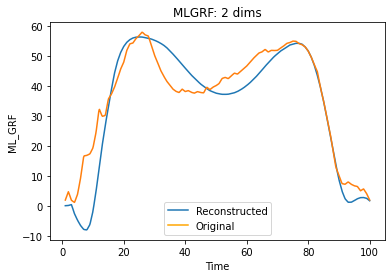

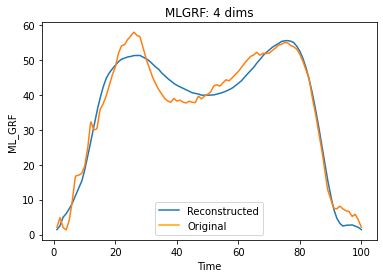

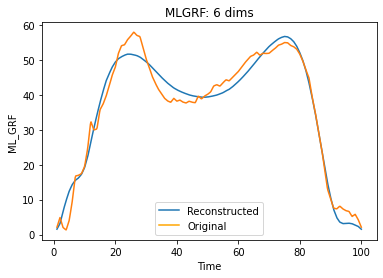

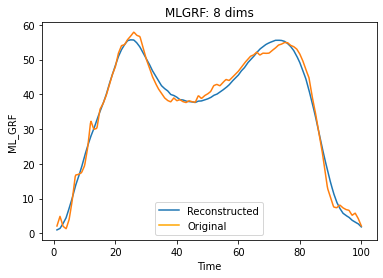

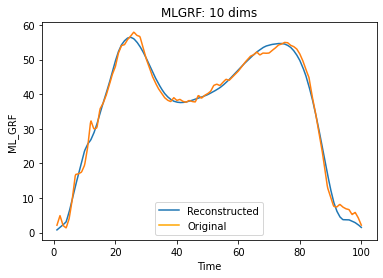

In [25]:
titles = ['MLGRF: 2 dims','MLGRF: 4 dims','MLGRF: 6 dims','MLGRF: 8 dims','MLGRF: 10 dims']

legend_elements = [Line2D([0], [0], label='Reconstructed'), 
                   Line2D([0], [0], color='orange', label='Original')]

for i in range(5):
    fig = comb_fd[i].plot()
    fig.show()
    plt.title(titles[i])
    plt.xlabel("Time")
    plt.ylabel("ML_GRF")
    plt.legend(handles = legend_elements)

# Latent Space Outlier Analysis

In [38]:
with torch.no_grad():
    recondata, latentmu, latentlv = models_npars[0](torch.tensor(ML_GRF_stance_N_matrix, dtype=torch.float32))
    recondata = recondata.numpy()
    latentmu = latentmu.numpy()
    latentlv = latentlv.numpy()

In [39]:
latent_PCA = PCA()
latent_PCA.fit(latentmu[trainidx])
latentmu_PCA = latent_PCA.transform(latentmu)

In [40]:
lof = LocalOutlierFactor()
lof.fit(latentmu_PCA)
outidx = np.argsort(lof.negative_outlier_factor_)

In [41]:
for i in range(10):
    j = outidx[i]
    print('O%i | ID : %i | Trial: %i | Leg: %s | Trial Length: %i' % (i+1, int(ID_info_matrix[j,0]), int(ID_info_matrix[j,2]), ID_info_matrix[j,1] , int(ID_info_matrix[j,3])))

O1 | ID : 1832 | Trial: 2 | Leg: LEFT | Trial Length: 778
O2 | ID : 217 | Trial: 2 | Leg: RIGHT | Trial Length: 761
O3 | ID : 1983 | Trial: 5 | Leg: RIGHT | Trial Length: 869
O4 | ID : 1479 | Trial: 4 | Leg: RIGHT | Trial Length: 698
O5 | ID : 612 | Trial: 3 | Leg: RIGHT | Trial Length: 842
O6 | ID : 1321 | Trial: 3 | Leg: LEFT | Trial Length: 817
O7 | ID : 1546 | Trial: 2 | Leg: RIGHT | Trial Length: 905
O8 | ID : 2244 | Trial: 4 | Leg: LEFT | Trial Length: 662
O9 | ID : 1257 | Trial: 2 | Leg: LEFT | Trial Length: 792
O10 | ID : 1493 | Trial: 4 | Leg: LEFT | Trial Length: 677


In [44]:
def plot_outliers(subsel, offset=3):
    ML_GRF_stance_N_out = ML_GRF_stance_N_matrix[outidx[subsel]].copy()
#    weigout = spec_weig[outidx[subsel]]

    ML_GRF_stance_N_out /= np.mean(np.abs(ML_GRF_stance_N_out), axis=1)[:,None]
    ML_GRF_stance_N_outfil = ML_GRF_stance_N_out.copy()
#    specoutfil[weigout == 0] = float('nan')

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    for i in range(len(subsel)):
        plt.plot(grid_points_100, ML_GRF_stance_N_out[i] + offset*i, zorder=-i-0.01, c=colors[subsel[i]], alpha=0.5)
        plt.plot(grid_points_100, ML_GRF_stance_N_outfil[i] + offset*i, zorder=-i, c=colors[subsel[i]])
        plt.text(grid_points_100[-1], ML_GRF_stance_N_out[i,-1] + i*offset, 'O%i' % (subsel[i]+1), color=colors[subsel[i]], fontsize='small')
#    plt.xlim((3250,8800))

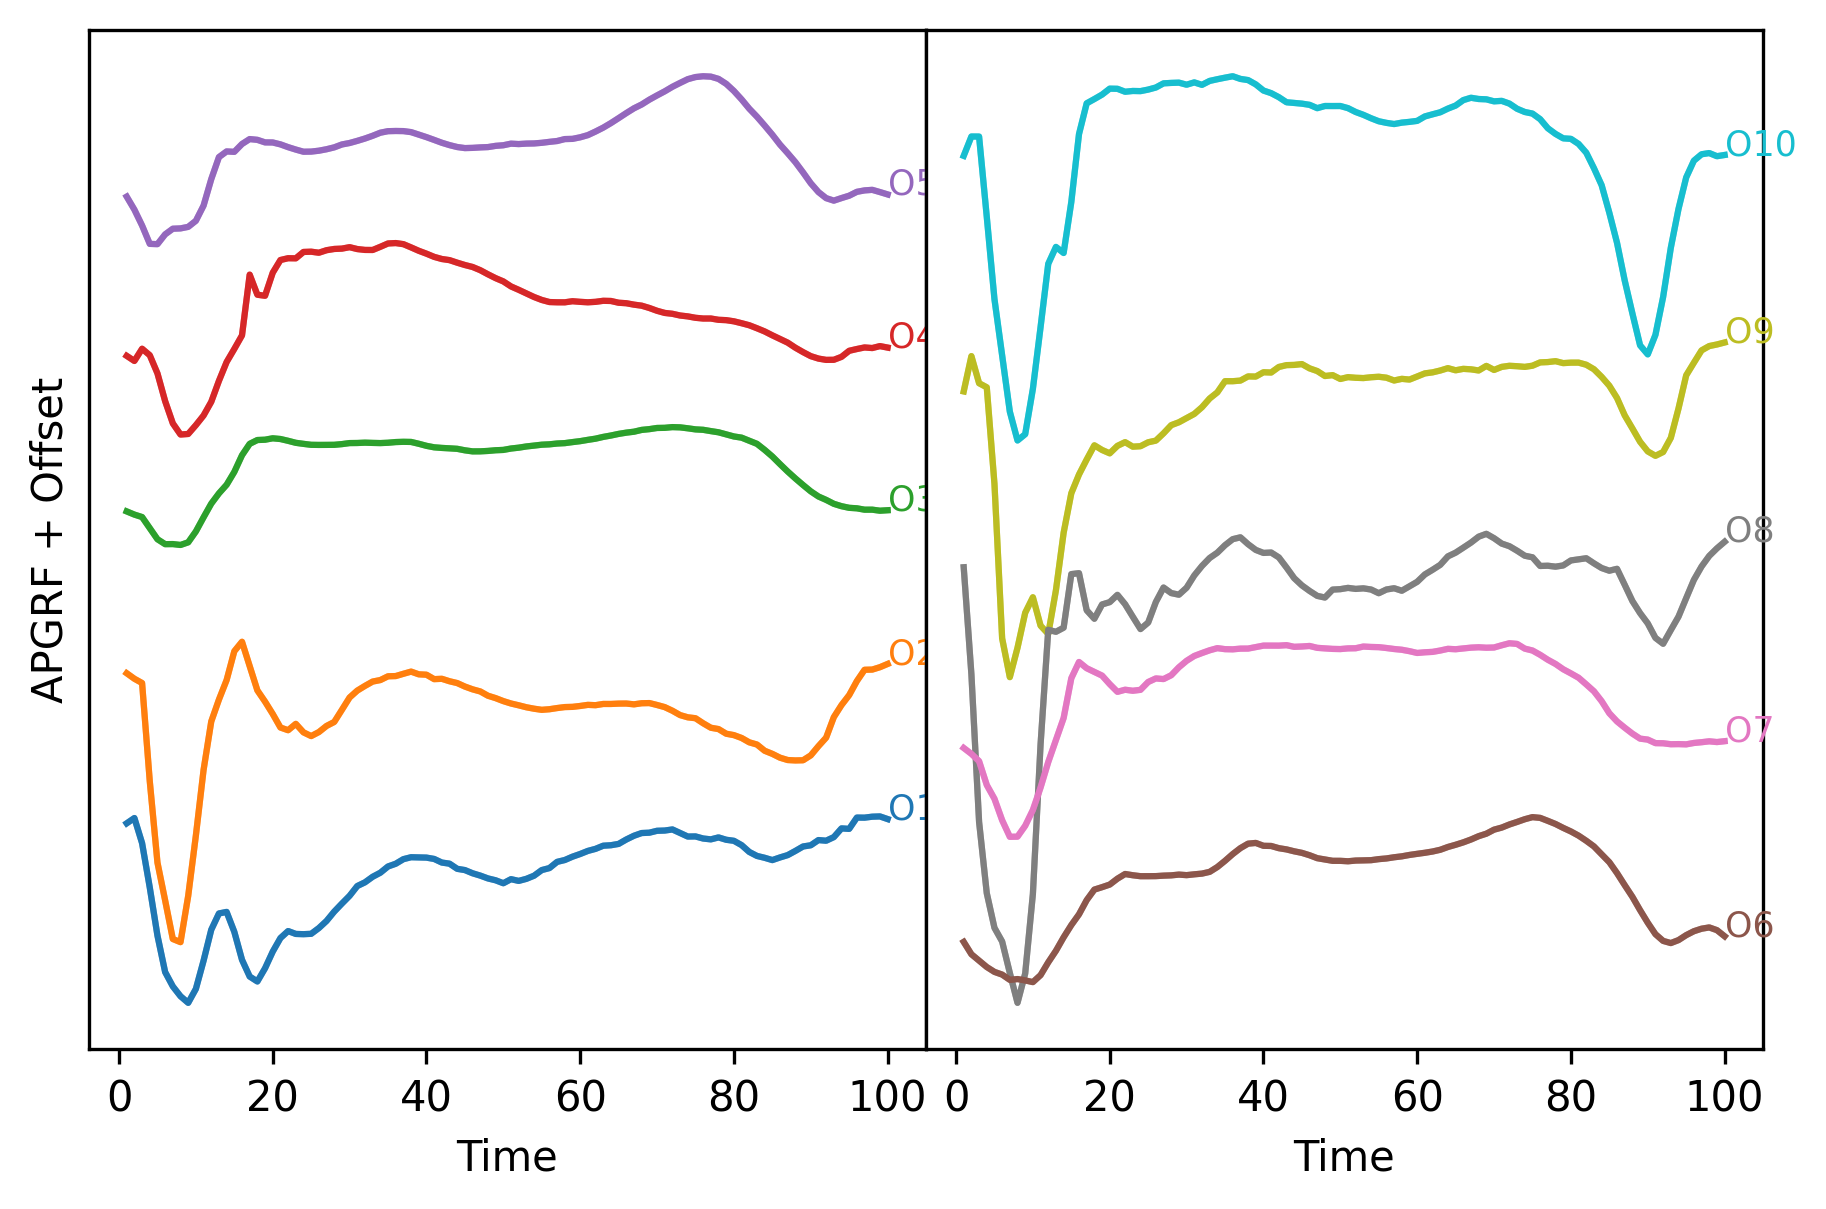

In [45]:
fig = plt.figure(figsize=(7.2,4.5), dpi=300)
fig.subplots_adjust(hspace=0, wspace=0)
plt.subplot(1,2,1)
plt.ylabel('APGRF + Offset')
plt.yticks([])
plt.xlabel('Time')
plot_outliers(range(0,5))
plt.subplot(1,2,2)
plot_outliers(range(5,10))
plt.yticks([])
plt.xlabel('Time')
#plt.savefig('figures/outliers.pdf')
plt.show()